# **Exploring the effectiveness of varying approaches in clustering tropical cyclone tracks**
\
In this notebook, we reproduce and extend some of the analysis carried out in "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) by Nakamura, Jennifer, et al.

Group 3: Ahinoam Toubia, Dhruv Chakraborty, Martin Celedon, Xingyao Li

In [1]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy

In [2]:
import os
import requests
import xarray as xr # x-array

cwd=os.getcwd()
cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc'
output_file = 'data/NA_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")

tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)

## Print the tks to take a peek at what's actually in the dataset.
print(tks)

File downloaded successfully.
<xarray.Dataset> Size: 618MB
Dimensions:           (storm: 2344, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 7MB ...
    lat               (storm, date_time) float32 3MB ...
    lon               (storm, date_time) float32 3MB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 9kB ...
    sid               (storm) |S13 30kB ...
    season            (storm) float32 9kB ...
    number            (storm) int16 5kB ...
    basin             (storm, date_time) |S2 2MB ...
    subbasin          (storm, date_time) |S2 2MB ...
    ...                ...
    reunion_gust      (storm, date_time) float32 3MB ...
    reunion_gust_per  (storm, date_time) float32 3MB ...
    usa_seahgt        (storm, date_time) float32 3MB ...
    usa_searad        (storm, date_time, quadrant) float32 14MB ...
    storm_speed       (storm, date_time) float32 3MB ...

In [3]:
# function definitions were moved to hurricane_utils.py for improving notebook readability
from hurricane_utils import * 

import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import numpy as np # numpy
import urllib.request # download request
import warnings # to suppress warnings
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Replicating application of K-means for clustering tropical cyclones in the North Atlantic

In [4]:
# Apply masks 
named_storm_mask = np.array([is_named_storm(tks.usa_status[i].values) 
                            for i in range(tks.dims['storm'])])
year_mask = tks.season >= 1950
valid_storms = np.logical_and(named_storm_mask, year_mask)


# Calculate moments for valid storms only
moment_lst = [get_moments(tks.sel(storm=i)) for i in range(tks.dims['storm'])
              if valid_storms[i] and get_moments(tks.sel(storm=i)) is not None]
moment_array = np.array(moment_lst)

# Standardize features
scaler = StandardScaler()
moment_array_normalized = scaler.fit_transform(moment_array)

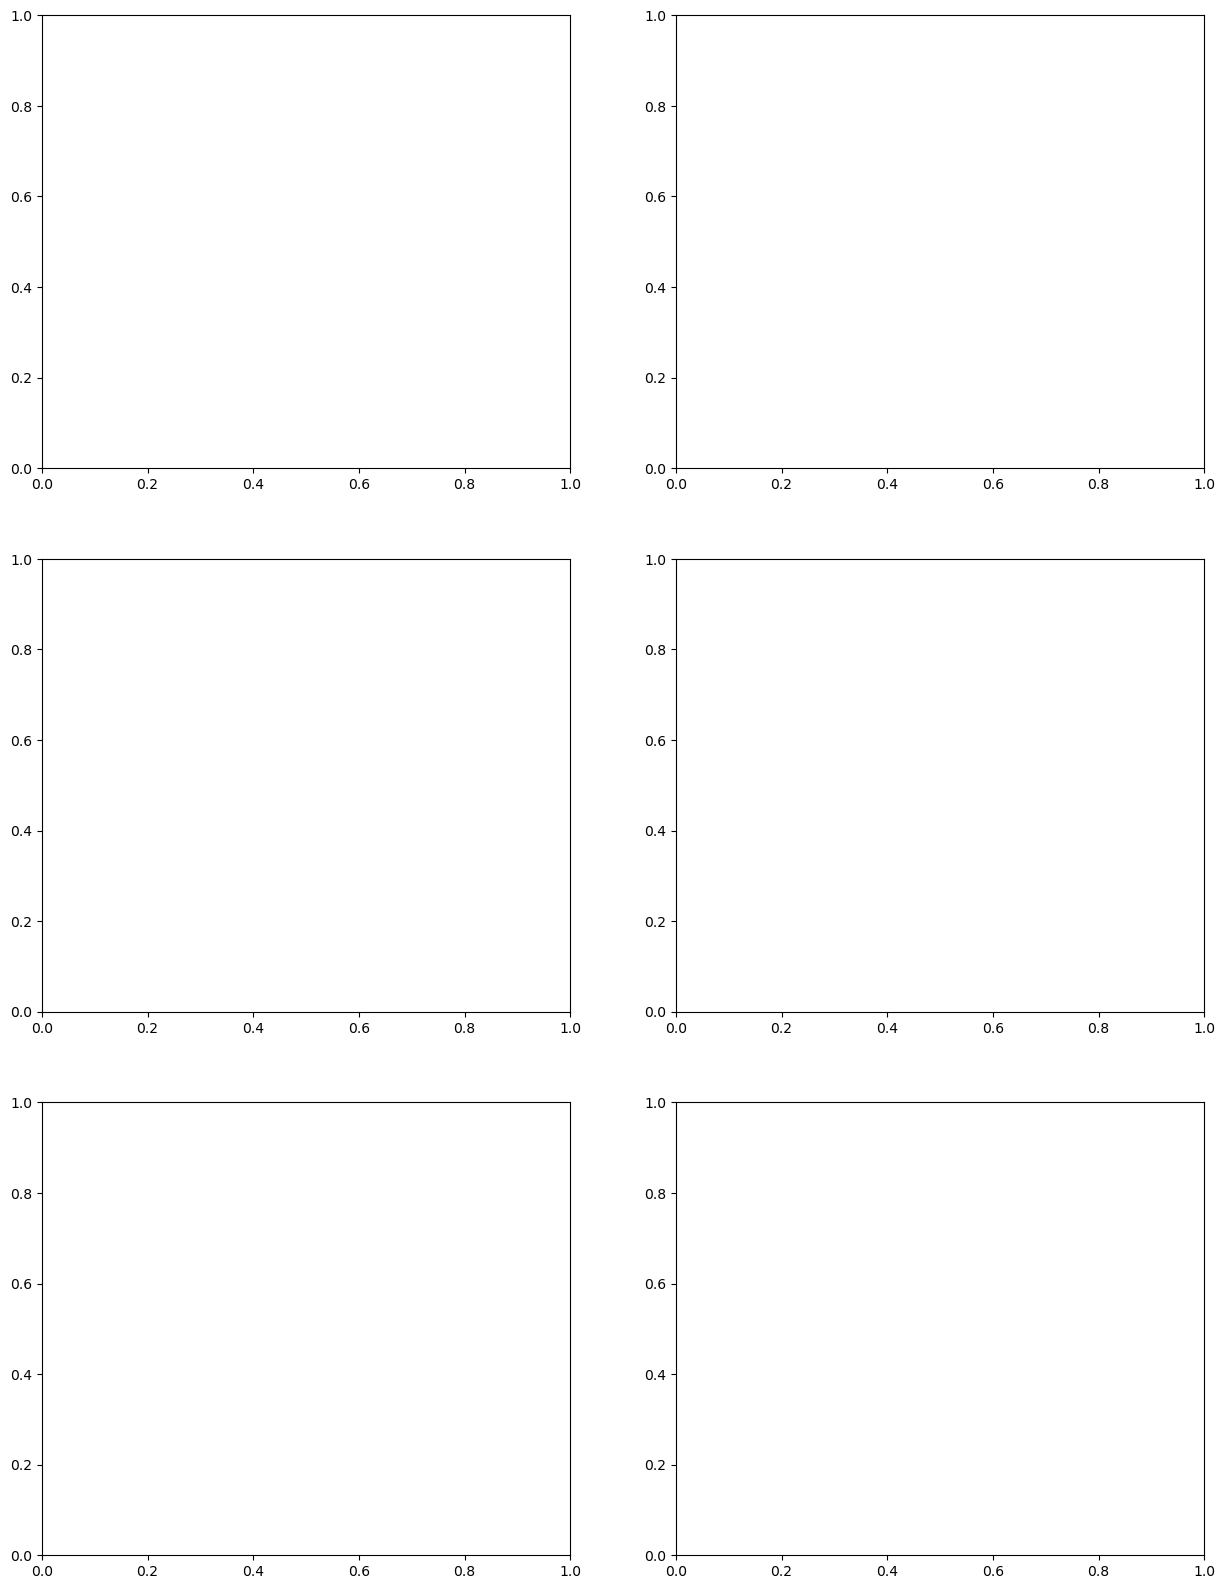

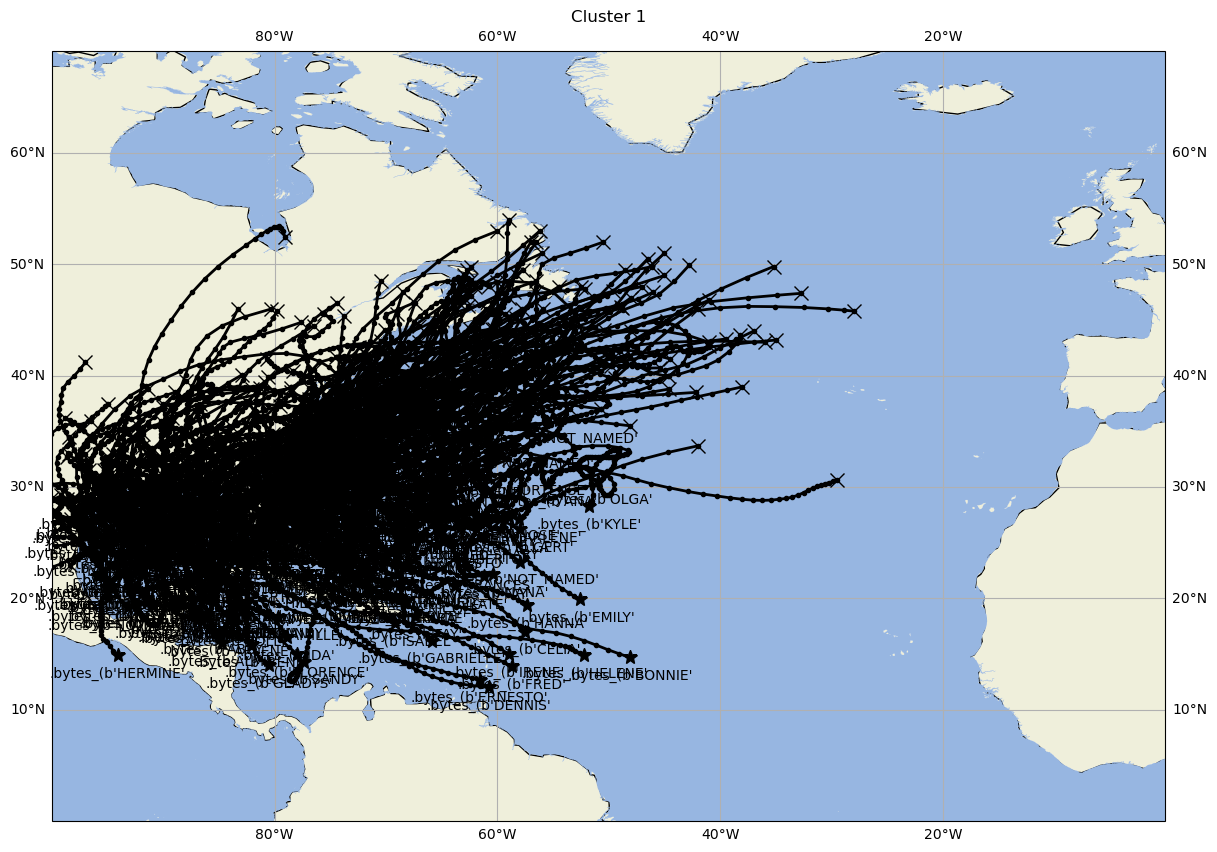

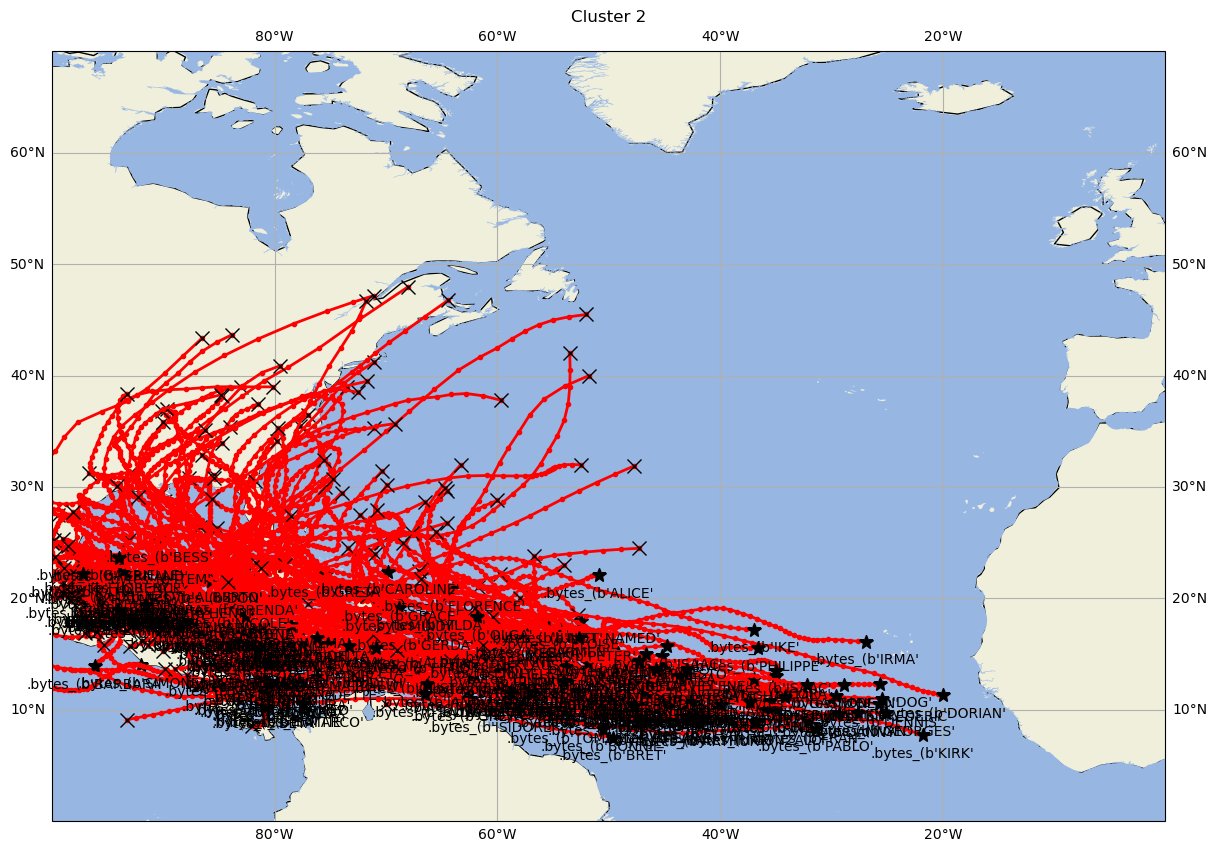

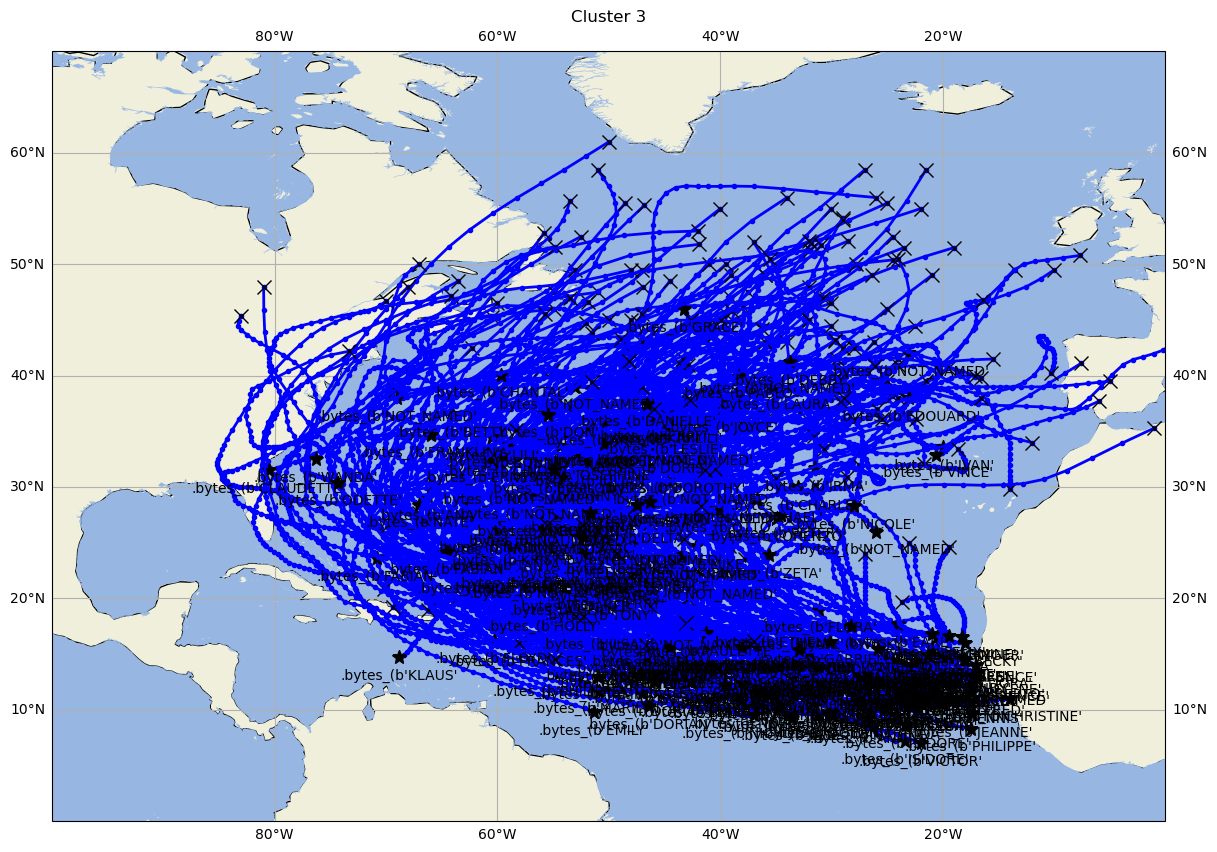

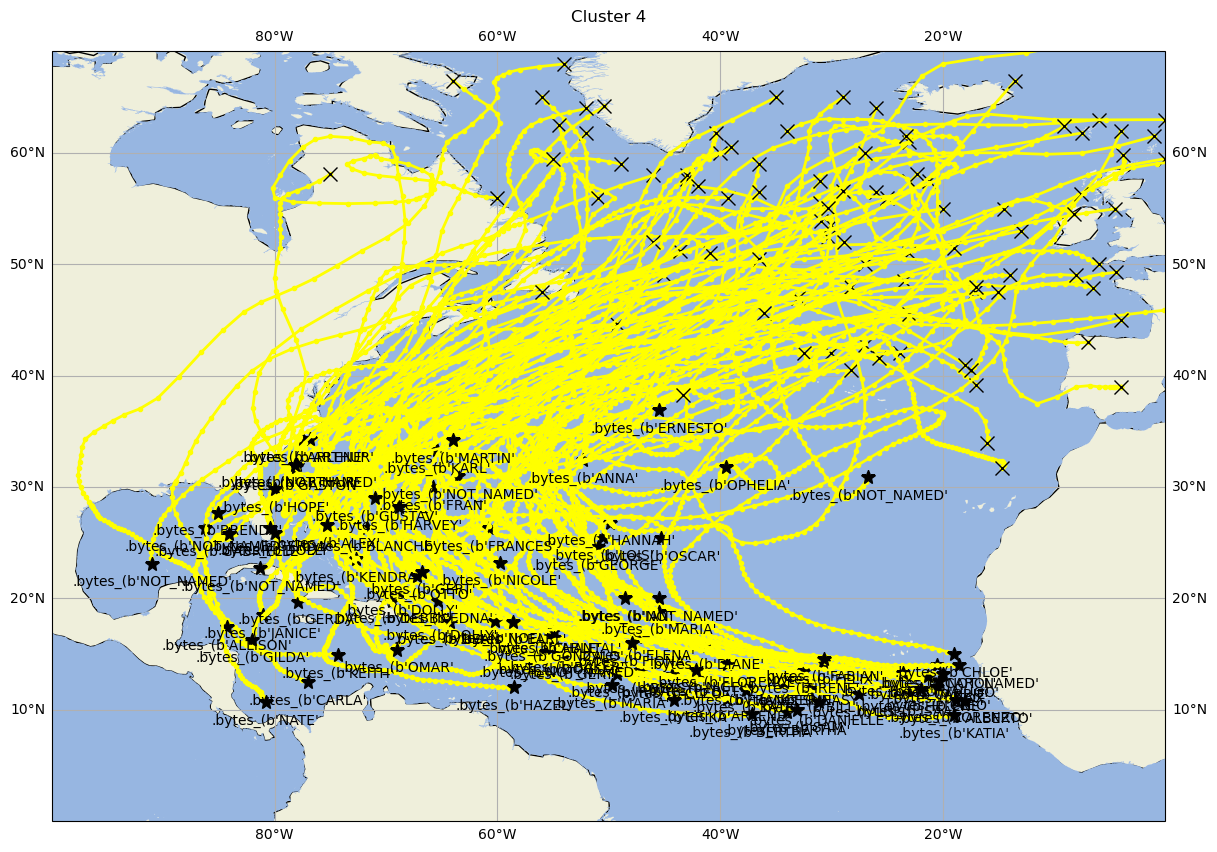

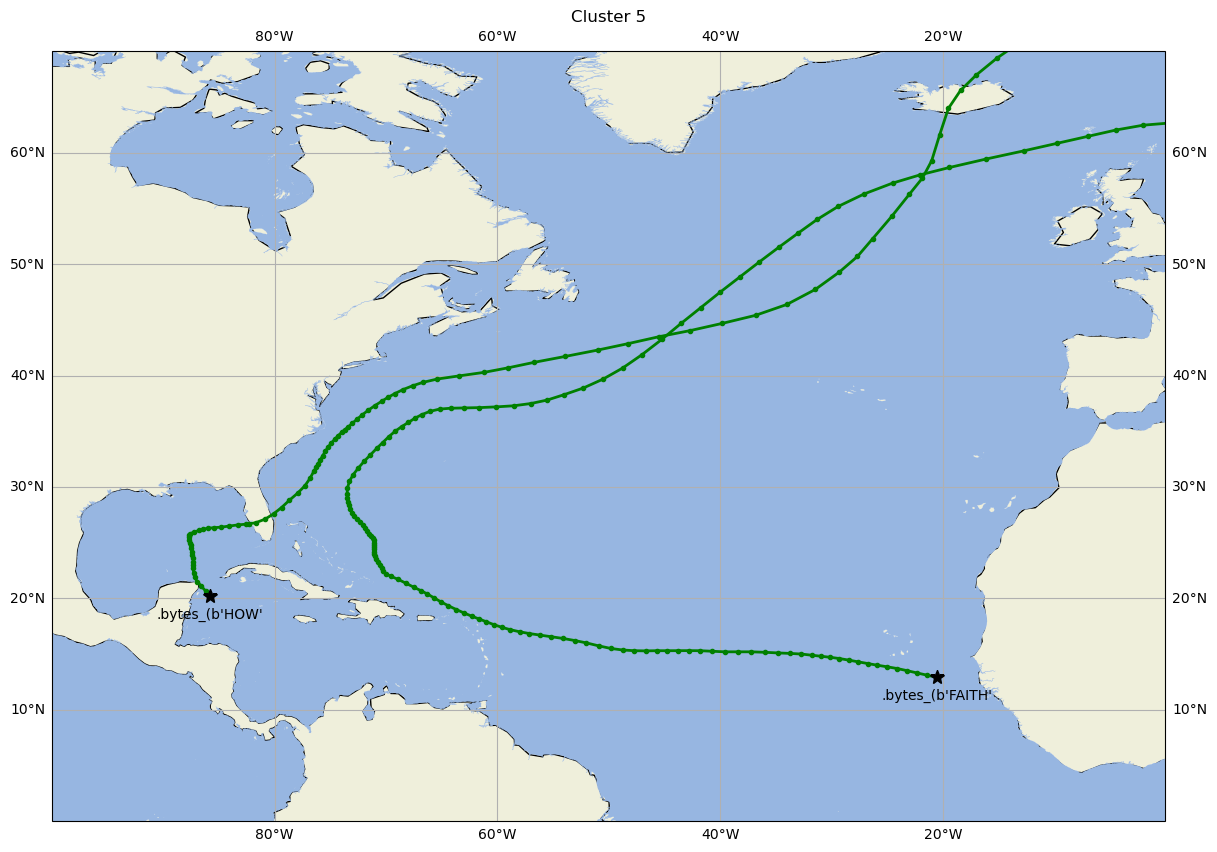

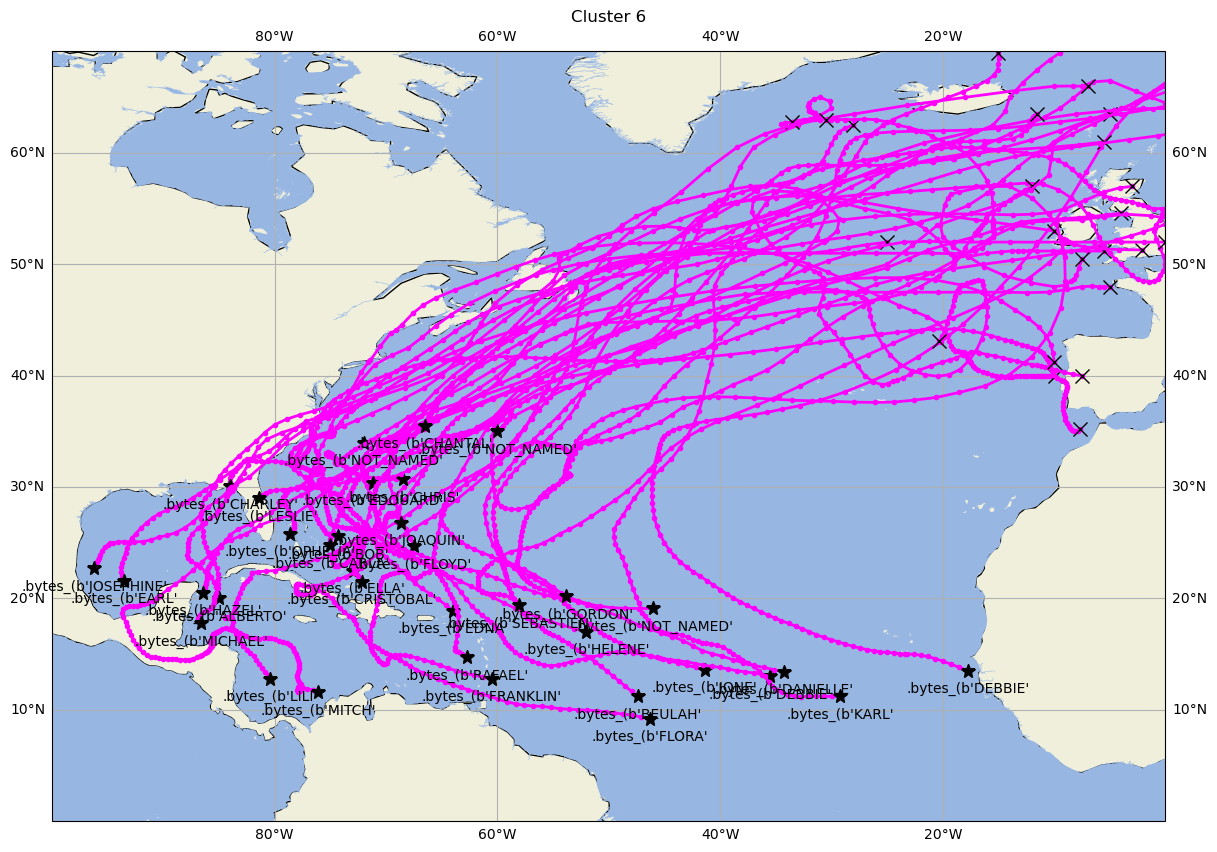

In [5]:
# Perform K-means clustering with k=6
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(moment_array_normalized)

# colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
# labels = kmeans[1]
# ax = map_background()
# for k in range(len(moment_lst)):
#     ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
# plt.title('K-means clustering result, 6 clusters')


# Create visualization of clusters
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.ravel()

for i in range(6):
    ax = map_background(extent=[-100, 0, 0, 60], label=True)
    
    # Plot tracks for this cluster
    cluster_indices = np.where(labels == i)[0]
    for idx in cluster_indices:
        storm_idx = valid_storms.values.nonzero()[0][idx]
        storm = tks.sel(storm=storm_idx)
        plot_one_track(ax, storm, color=colors[i], marker_color='black')
        
    plt.title(f'Cluster {i+1}')
    plt.show()


Cluster 1 Statistics:
Number of storms: 292
Average maximum wind speed: 23.8 knots
Average life span: 11.7 days


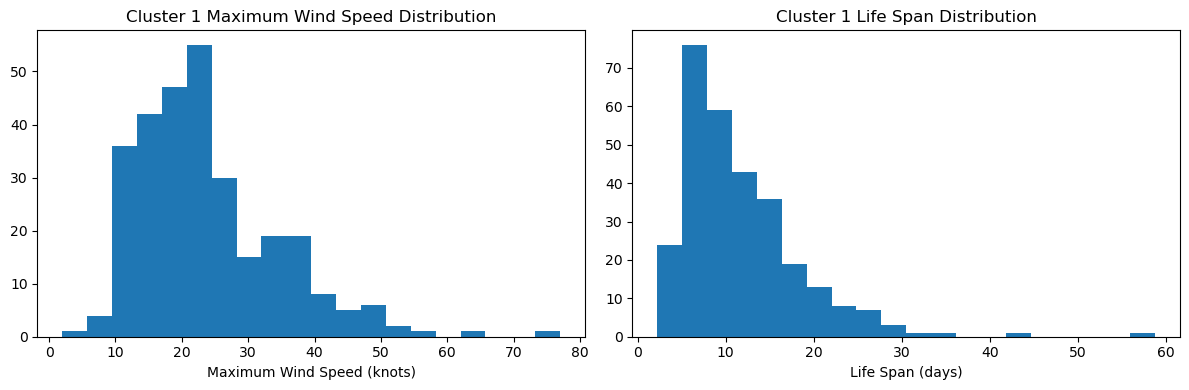


Cluster 2 Statistics:
Number of storms: 228
Average maximum wind speed: 19.0 knots
Average life span: 13.9 days


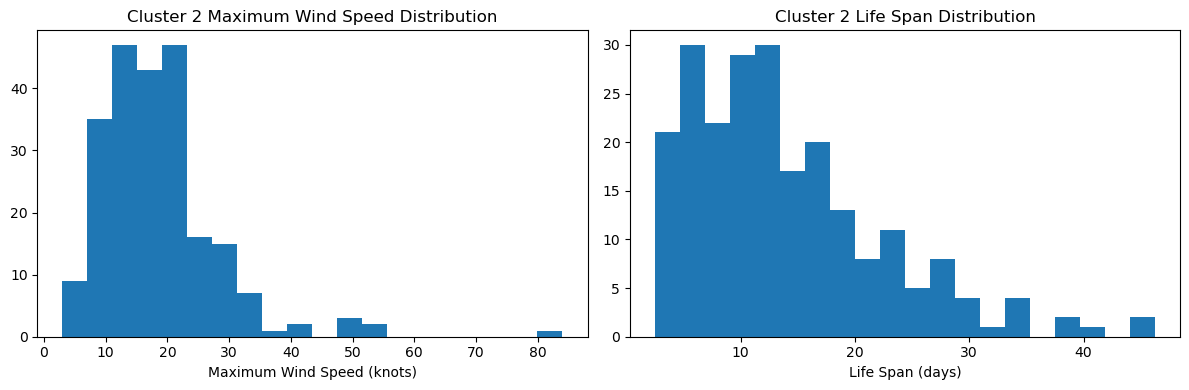


Cluster 3 Statistics:
Number of storms: 253
Average maximum wind speed: 27.7 knots
Average life span: 18.1 days


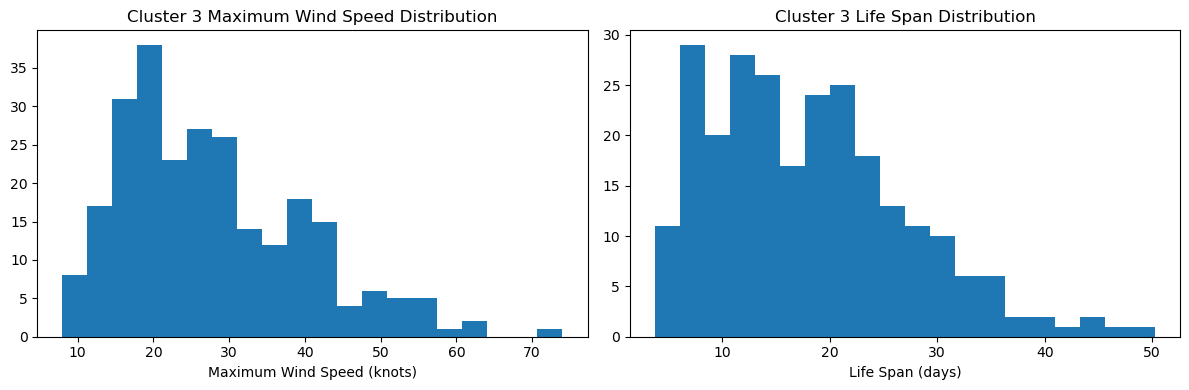


Cluster 4 Statistics:
Number of storms: 98
Average maximum wind speed: 41.4 knots
Average life span: 22.4 days


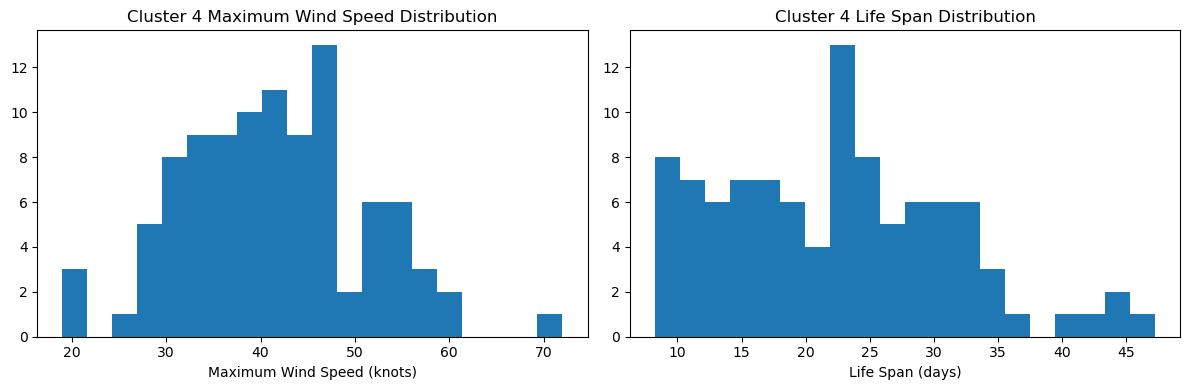


Cluster 5 Statistics:
Number of storms: 2
Average maximum wind speed: 42.5 knots
Average life span: 36.9 days


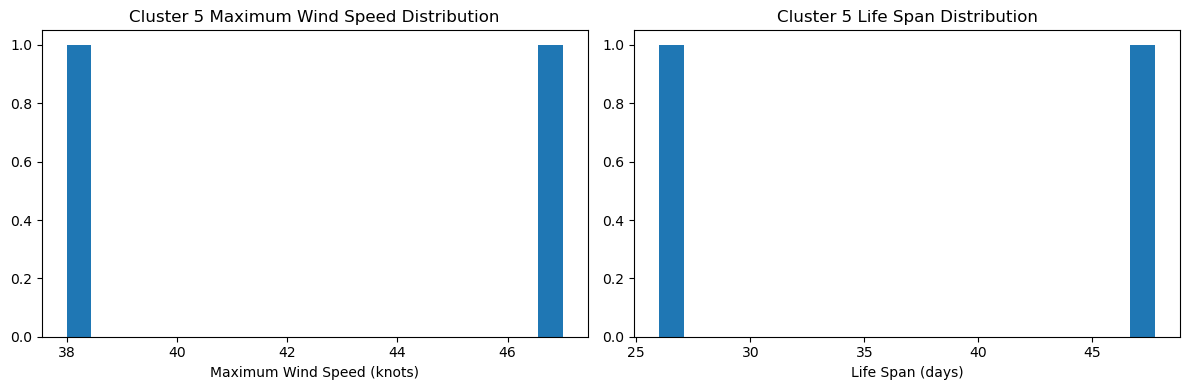


Cluster 6 Statistics:
Number of storms: 35
Average maximum wind speed: 42.1 knots
Average life span: 24.6 days


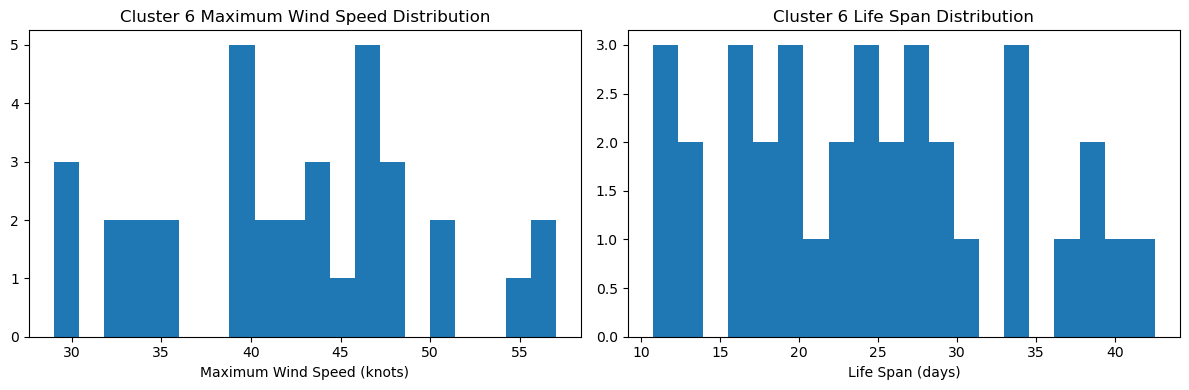

In [6]:
# Calculate and plot characteristics for each cluster
for i in range(6):
    cluster_indices = np.where(labels == i)[0]
    print(f"\nCluster {i+1} Statistics:")
    print(f"Number of storms: {len(cluster_indices)}")
    
    # Get storms in this cluster
    cluster_storms = [tks.sel(storm=valid_storms.values.nonzero()[0][idx]) 
                     for idx in cluster_indices]
    
    # Calculate statistics
    max_winds = [np.nanmax(storm.storm_speed.values) for storm in cluster_storms]
    lifespans = [np.sum(~np.isnan(storm.lon.values)) * 6 / 24 for storm in cluster_storms]  # in days
    
    print(f"Average maximum wind speed: {np.mean(max_winds):.1f} knots")
    print(f"Average life span: {np.mean(lifespans):.1f} days")
    
    # Plot distributions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.hist(max_winds, bins=20)
    ax1.set_title(f'Cluster {i+1} Maximum Wind Speed Distribution')
    ax1.set_xlabel('Maximum Wind Speed (knots)')
    
    ax2.hist(lifespans, bins=20)
    ax2.set_title(f'Cluster {i+1} Life Span Distribution')
    ax2.set_xlabel('Life Span (days)')
    
    plt.tight_layout()
    plt.show()

In [7]:
# for life span:

# import pandas as pd

# # Load your dataset (assuming it's a CSV file)
# df = pd.read_csv("your_data.csv", parse_dates=["ISO_TIME"])

# # Select a specific storm by SID
# storm_id = "your_storm_id"  # Replace with actual storm ID
# storm_data = df[df["SID"] == storm_id]

# # Get the first and last recorded timestamps
# start_time = storm_data["ISO_TIME"].min()
# end_time = storm_data["ISO_TIME"].max()

# # Calculate duration
# duration = end_time - start_time
# print(f"Storm {storm_id} was active for: {duration}")

### Trying out other clustering strategies

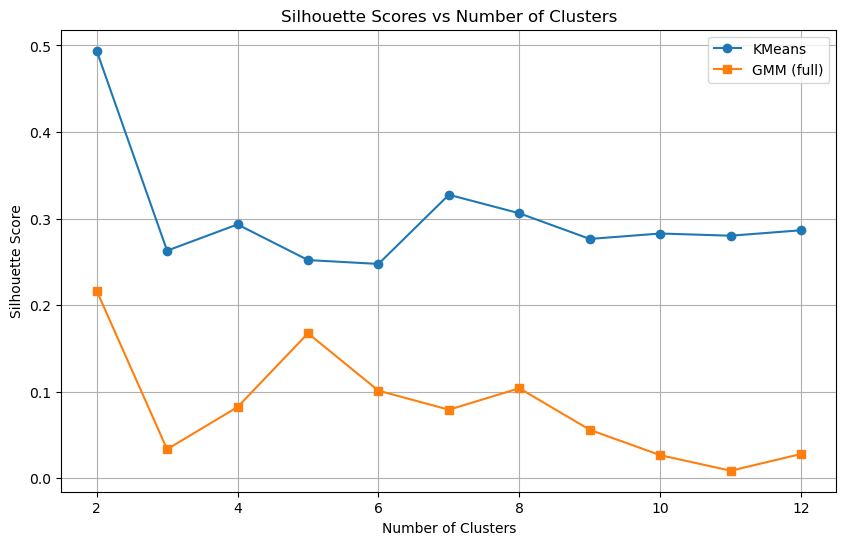

Optimal clusters for KMeans: 2
Optimal clusters for GMM: 2


In [8]:
# Range of clusters to test
n_clusters_range = range(2, 13)
silhouette_kmeans = []
silhouette_gmm = []

# Calculate silhouette scores for each number of clusters
for n_clusters in n_clusters_range:
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(moment_array_normalized)
    silhouette_kmeans.append(silhouette_score(moment_array_normalized, kmeans_labels))
    
    # GMM with full covariance
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
    gmm_labels = gmm.fit_predict(moment_array_normalized)
    silhouette_gmm.append(silhouette_score(moment_array_normalized, gmm_labels))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_kmeans, 'o-', label='KMeans')
plt.plot(n_clusters_range, silhouette_gmm, 's-', label='GMM (full)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores vs Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

# Print optimal number of clusters for each method
print(f"Optimal clusters for KMeans: {n_clusters_range[np.argmax(silhouette_kmeans)]}")
print(f"Optimal clusters for GMM: {n_clusters_range[np.argmax(silhouette_gmm)]}")


In [9]:
moment_array

array([[-63.81708908,  32.59141541, 119.54717438, 142.21128141,
         77.56675425],
       [-74.72615051,  21.7166996 , 170.54376423,  39.53584339,
        -69.76233712],
       [-50.42780304,  24.65010262, 101.25622322, 110.9665425 ,
        -91.78420078],
       ...,
       [-49.4561615 ,  20.86382866,  12.86120466,   9.3040745 ,
        -10.85417833],
       [-41.33311081,  14.52972507,  36.97995891,   8.05654406,
        -17.08128206],
       [-57.89866257,  23.75381851,  23.45498627,  47.98790387,
          3.89529025]])

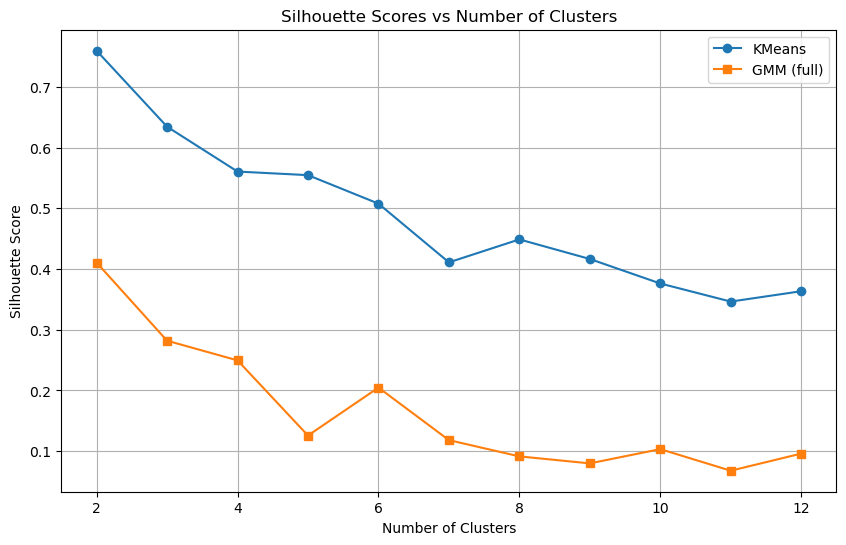

Optimal clusters for KMeans: 2
Optimal clusters for GMM: 2


In [10]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Range of clusters to test
n_clusters_range = range(2, 13)
silhouette_kmeans = []
silhouette_gmm = []

# Calculate silhouette scores for each number of clusters
for n_clusters in n_clusters_range:
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(moment_array)
    silhouette_kmeans.append(silhouette_score(moment_array, kmeans_labels))
    
    # GMM with full covariance
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
    gmm_labels = gmm.fit_predict(moment_array)
    silhouette_gmm.append(silhouette_score(moment_array, gmm_labels))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_kmeans, 'o-', label='KMeans')
plt.plot(n_clusters_range, silhouette_gmm, 's-', label='GMM (full)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores vs Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

# Print optimal number of clusters for each method
print(f"Optimal clusters for KMeans: {n_clusters_range[np.argmax(silhouette_kmeans)]}")
print(f"Optimal clusters for GMM: {n_clusters_range[np.argmax(silhouette_gmm)]}")


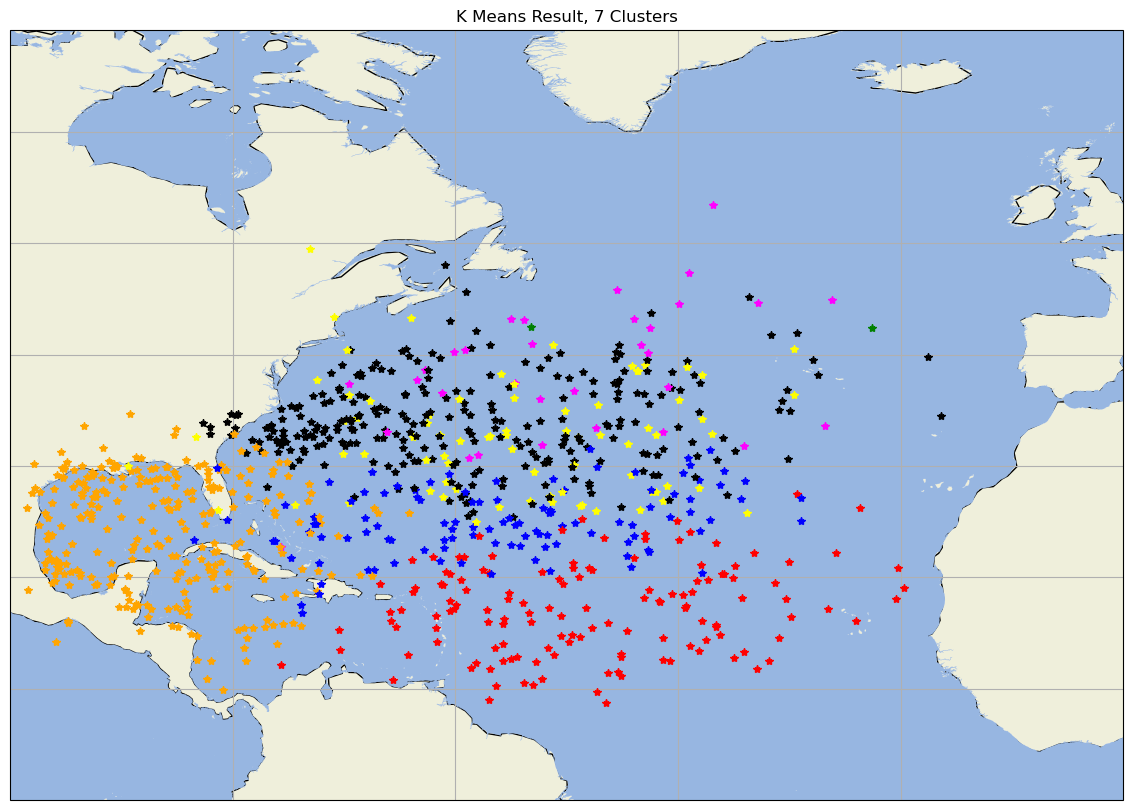

In [11]:
kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(moment_array_normalized)

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 
          'orange', 'gray', 'white', 'cyan', 'purple', 'brown']
ax = map_background() 
for k in range(len(moment_array)):
    ax.plot(moment_array[k][0], moment_array[k][1], c=colors[labels[k]], marker='*')
plt.title(f'K Means Result, {7} Clusters')
plt.show()

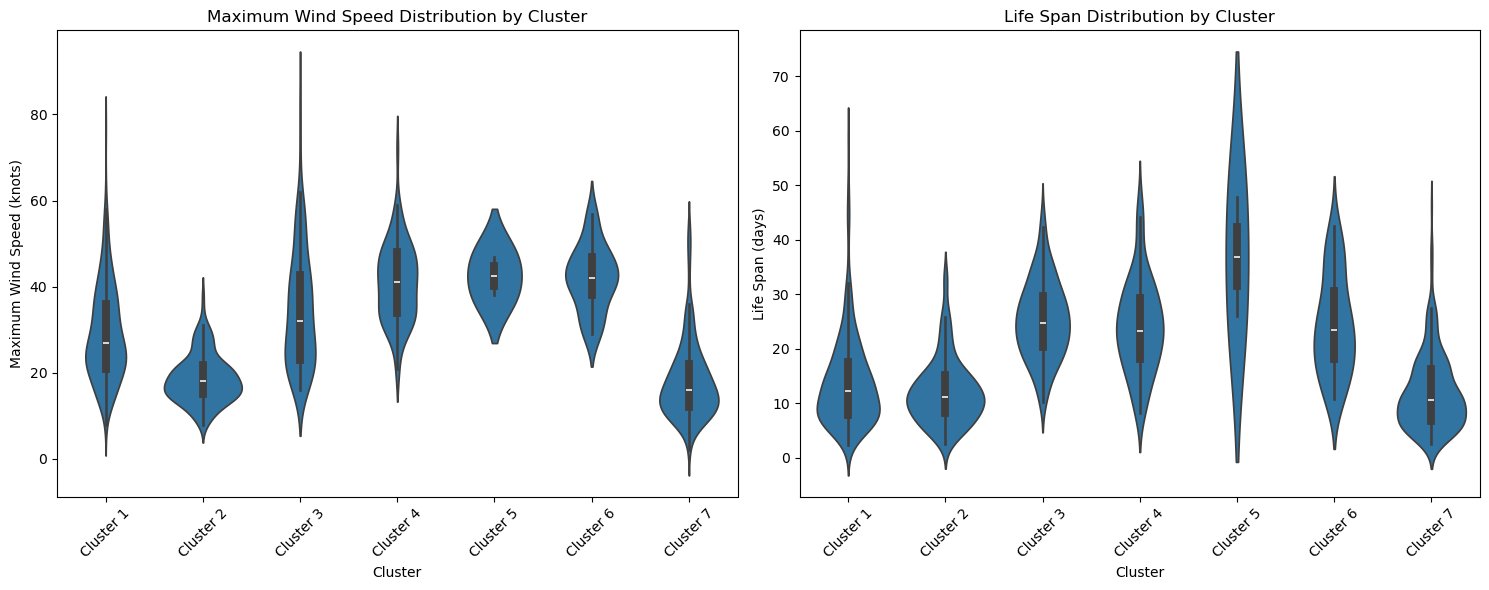


Cluster 1 Statistics:
Number of storms: 271
Average maximum wind speed: 29.2 knots
Average life span: 13.9 days

Cluster 2 Statistics:
Number of storms: 138
Average maximum wind speed: 18.6 knots
Average life span: 12.2 days

Cluster 3 Statistics:
Number of storms: 110
Average maximum wind speed: 34.7 knots
Average life span: 25.3 days

Cluster 4 Statistics:
Number of storms: 76
Average maximum wind speed: 40.9 knots
Average life span: 24.2 days

Cluster 5 Statistics:
Number of storms: 2
Average maximum wind speed: 42.5 knots
Average life span: 36.9 days

Cluster 6 Statistics:
Number of storms: 32
Average maximum wind speed: 42.0 knots
Average life span: 24.3 days

Cluster 7 Statistics:
Number of storms: 279
Average maximum wind speed: 18.1 knots
Average life span: 12.1 days


In [12]:
# Initialize lists to store data for all clusters
all_max_winds = []
all_lifespans = []
cluster_labels = []

for i in range(7):
    cluster_indices = np.where(labels == i)[0]
    
    # Get storms in this cluster
    cluster_storms = [tks.sel(storm=valid_storms.values.nonzero()[0][idx]) 
                     for idx in cluster_indices]
    
    # Calculate statistics
    max_winds = [np.nanmax(storm.storm_speed.values) for storm in cluster_storms]
    lifespans = [np.sum(~np.isnan(storm.lon.values)) * 6 / 24 for storm in cluster_storms]
    
    all_max_winds.extend(max_winds)
    all_lifespans.extend(lifespans)
    cluster_labels.extend([f'Cluster {i+1}'] * len(cluster_indices))

# Create violin plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot wind speeds
sns.violinplot(x=cluster_labels, y=all_max_winds, ax=ax1)
ax1.set_title('Maximum Wind Speed Distribution by Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Maximum Wind Speed (knots)')
ax1.tick_params(axis='x', rotation=45)

# Plot lifespans
sns.violinplot(x=cluster_labels, y=all_lifespans, ax=ax2)
ax2.set_title('Life Span Distribution by Cluster')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Life Span (days)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
for i in range(7):
    cluster_indices = np.where(labels == i)[0]
    print(f"\nCluster {i+1} Statistics:")
    print(f"Number of storms: {len(cluster_indices)}")
    print(f"Average maximum wind speed: {np.mean([w for j, w in enumerate(all_max_winds) if cluster_labels[j] == f'Cluster {i+1}']):.1f} knots")
    print(f"Average life span: {np.mean([l for j, l in enumerate(all_lifespans) if cluster_labels[j] == f'Cluster {i+1}']):.1f} days")


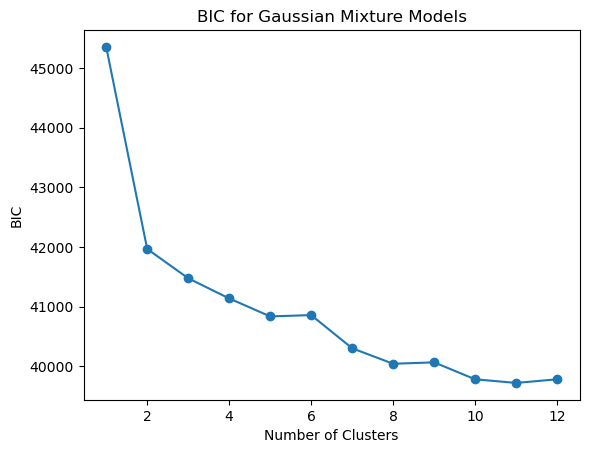

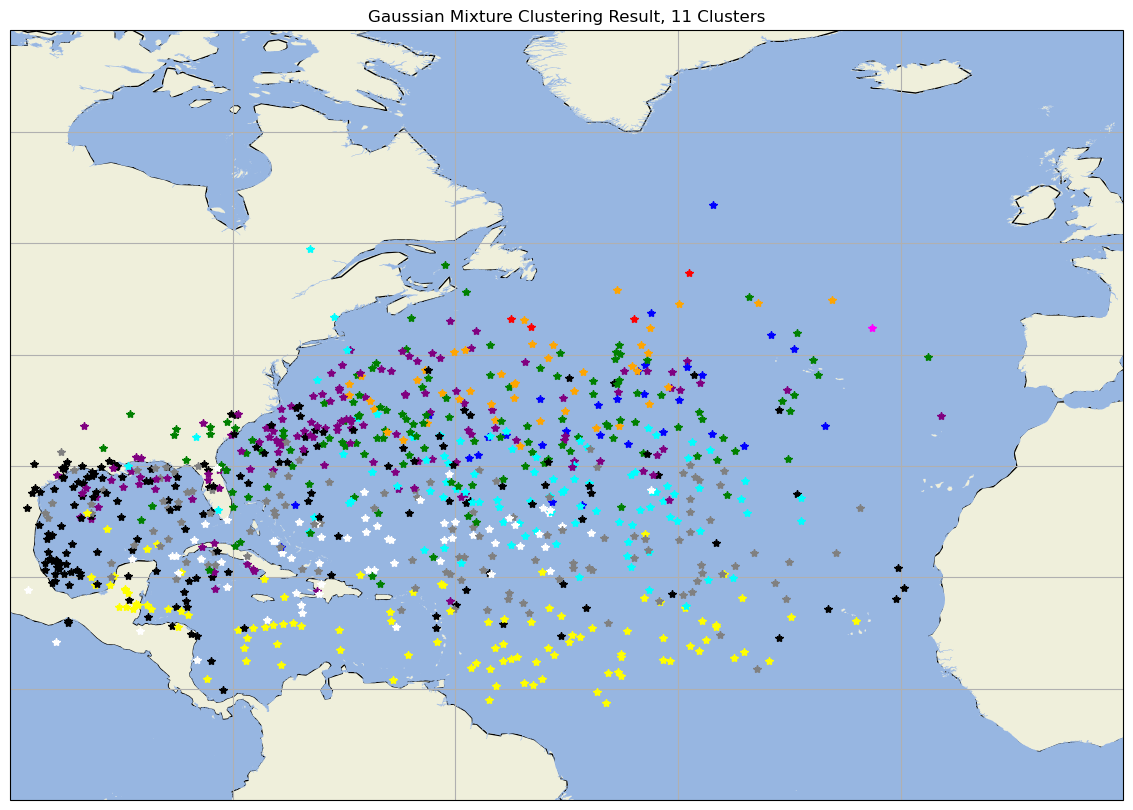

In [13]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# list to numpy array
moment_array = np.array(moment_lst) 

n_components_range = range(1, 13)
bic = []

# Calculate BIC to select the optimal number of clusters
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(moment_array)  
    bic.append(gmm.bic(moment_array))

plt.figure()
plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.title('BIC for Gaussian Mixture Models')
plt.show()

# Choose the optimal number of clusters and fit the model
optimal_n = n_components_range[np.argmin(bic)]
gmm = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=42)
gmm.fit(moment_array)
labels = gmm.predict(moment_array)

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 
          'orange', 'gray', 'white', 'cyan', 'purple', 'brown']
ax = map_background() 
for k in range(len(moment_array)):
    ax.plot(moment_array[k][0], moment_array[k][1], c=colors[labels[k]], marker='*')
plt.title(f'Gaussian Mixture Clustering Result, {optimal_n} Clusters')
plt.show()

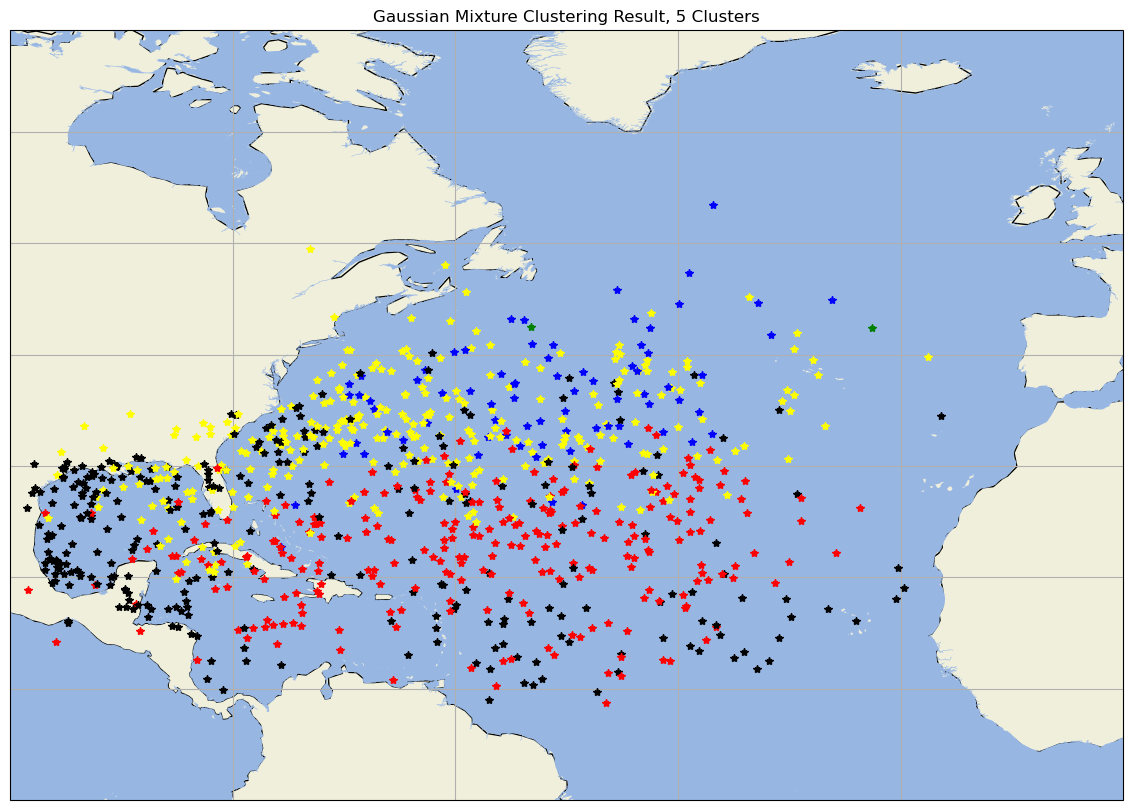

In [14]:
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm.fit(moment_array)
labels = gmm.predict(moment_array)

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 
          'orange', 'gray', 'white', 'cyan', 'purple', 'brown']
ax = map_background() 
for k in range(len(moment_array)):
    ax.plot(moment_array[k][0], moment_array[k][1], c=colors[labels[k]], marker='*')
plt.title(f'Gaussian Mixture Clustering Result, {5} Clusters')
plt.show()

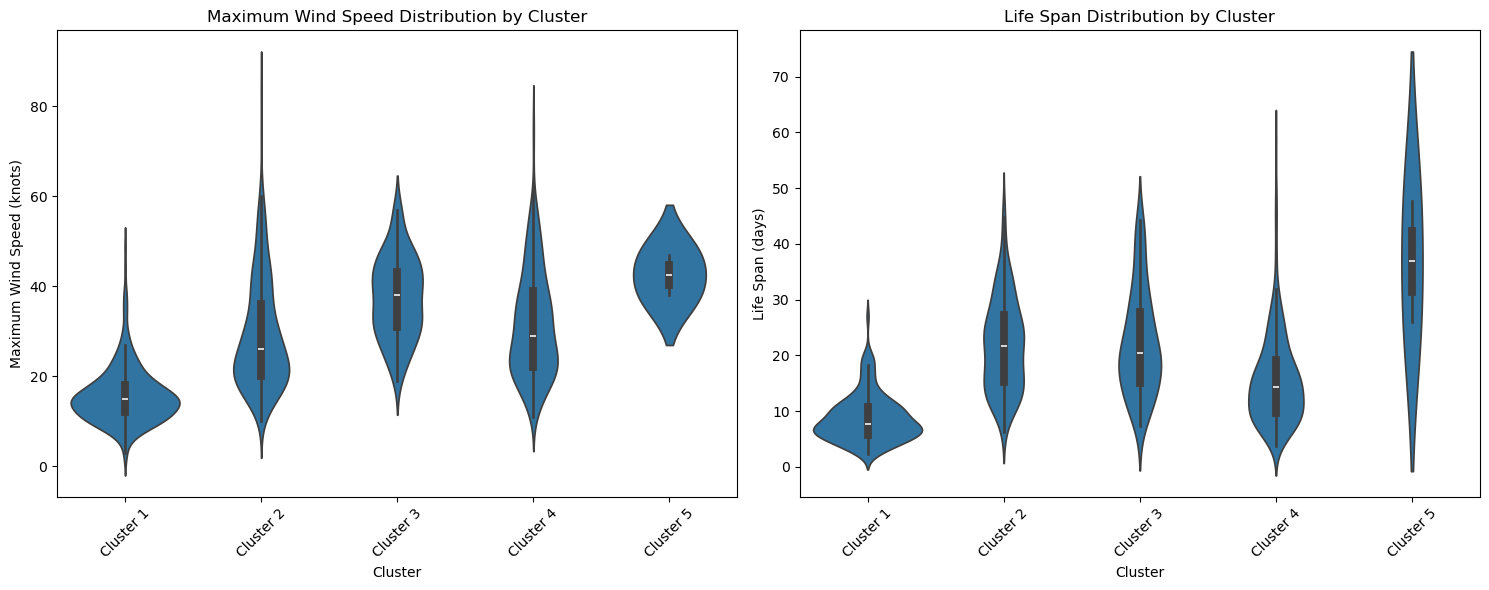


Cluster 1 Statistics:
Number of storms: 294
Average maximum wind speed: 15.7 knots
Average life span: 8.7 days

Cluster 2 Statistics:
Number of storms: 253
Average maximum wind speed: 29.3 knots
Average life span: 21.9 days

Cluster 3 Statistics:
Number of storms: 76
Average maximum wind speed: 37.5 knots
Average life span: 22.3 days

Cluster 4 Statistics:
Number of storms: 283
Average maximum wind speed: 31.6 knots
Average life span: 15.6 days

Cluster 5 Statistics:
Number of storms: 2
Average maximum wind speed: 42.5 knots
Average life span: 36.9 days

Cluster 6 Statistics:
Number of storms: 0
Average maximum wind speed: nan knots
Average life span: nan days


In [15]:
# Initialize lists to store data for all clusters
all_max_winds = []
all_lifespans = []
cluster_labels = []

for i in range(6):
    cluster_indices = np.where(labels == i)[0]
    
    # Get storms in this cluster
    cluster_storms = [tks.sel(storm=valid_storms.values.nonzero()[0][idx]) 
                     for idx in cluster_indices]
    
    # Calculate statistics
    max_winds = [np.nanmax(storm.storm_speed.values) for storm in cluster_storms]
    lifespans = [np.sum(~np.isnan(storm.lon.values)) * 6 / 24 for storm in cluster_storms]
    
    all_max_winds.extend(max_winds)
    all_lifespans.extend(lifespans)
    cluster_labels.extend([f'Cluster {i+1}'] * len(cluster_indices))

# Create violin plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot wind speeds
sns.violinplot(x=cluster_labels, y=all_max_winds, ax=ax1)
ax1.set_title('Maximum Wind Speed Distribution by Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Maximum Wind Speed (knots)')
ax1.tick_params(axis='x', rotation=45)

# Plot lifespans
sns.violinplot(x=cluster_labels, y=all_lifespans, ax=ax2)
ax2.set_title('Life Span Distribution by Cluster')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Life Span (days)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
for i in range(6):
    cluster_indices = np.where(labels == i)[0]
    print(f"\nCluster {i+1} Statistics:")
    print(f"Number of storms: {len(cluster_indices)}")
    print(f"Average maximum wind speed: {np.mean([w for j, w in enumerate(all_max_winds) if cluster_labels[j] == f'Cluster {i+1}']):.1f} knots")
    print(f"Average life span: {np.mean([l for j, l in enumerate(all_lifespans) if cluster_labels[j] == f'Cluster {i+1}']):.1f} days")



Testing nearest_neighbors affinity:

Number of clusters: 4
Silhouette Score: 0.160


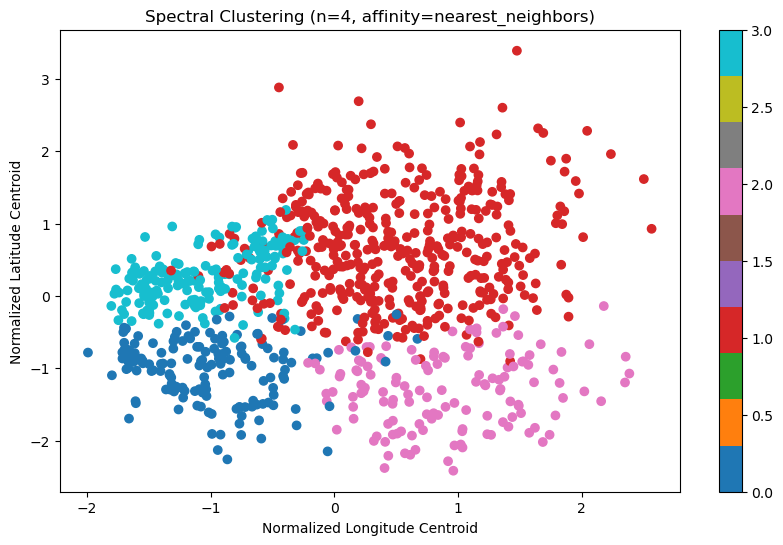


Cluster sizes:
Cluster 0: 158 points
Cluster 1: 436 points
Cluster 2: 137 points
Cluster 3: 177 points

Number of clusters: 5
Silhouette Score: 0.183


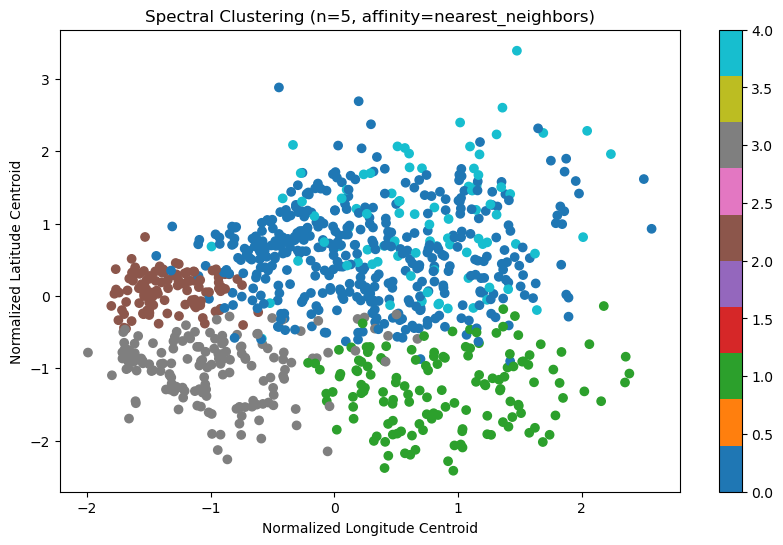


Cluster sizes:
Cluster 0: 412 points
Cluster 1: 139 points
Cluster 2: 109 points
Cluster 3: 159 points
Cluster 4: 89 points

Number of clusters: 6
Silhouette Score: 0.220


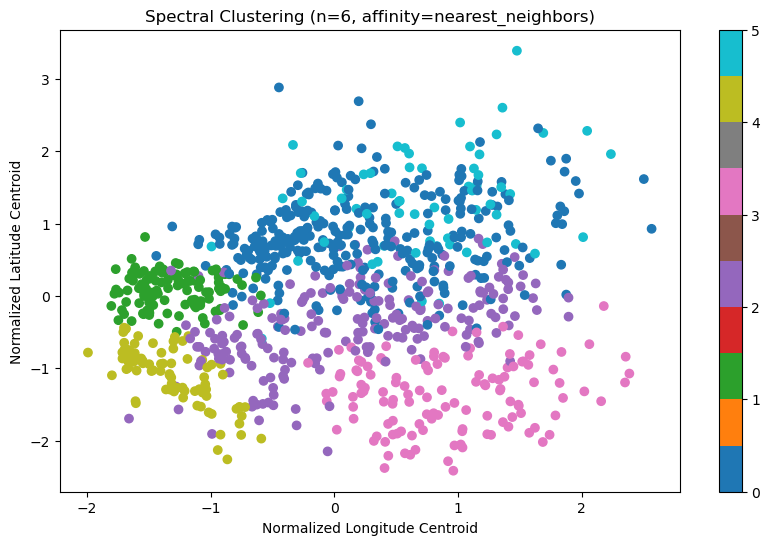


Cluster sizes:
Cluster 0: 312 points
Cluster 1: 111 points
Cluster 2: 209 points
Cluster 3: 125 points
Cluster 4: 85 points
Cluster 5: 66 points

Number of clusters: 7
Silhouette Score: 0.224


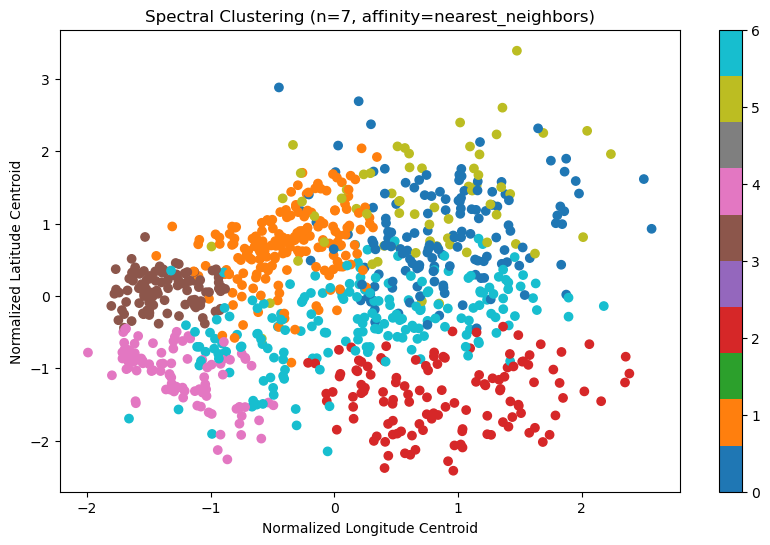


Cluster sizes:
Cluster 0: 145 points
Cluster 1: 181 points
Cluster 2: 124 points
Cluster 3: 101 points
Cluster 4: 97 points
Cluster 5: 66 points
Cluster 6: 194 points

Number of clusters: 8
Silhouette Score: 0.207


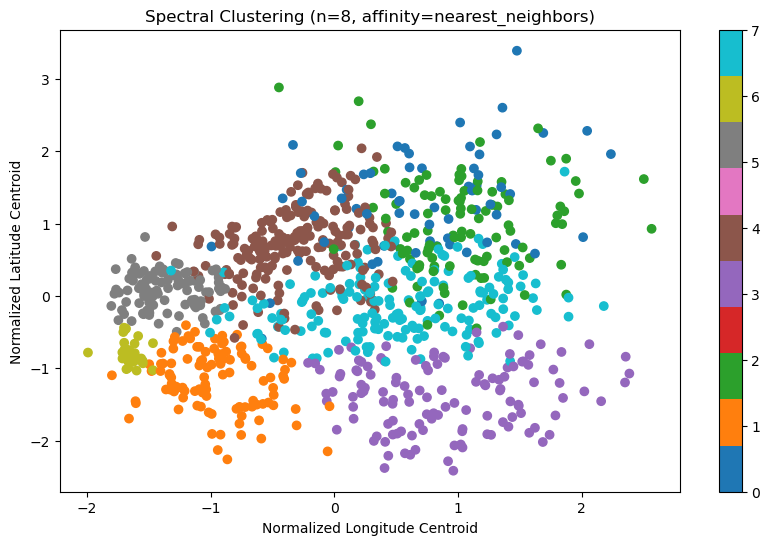


Cluster sizes:
Cluster 0: 67 points
Cluster 1: 106 points
Cluster 2: 108 points
Cluster 3: 124 points
Cluster 4: 200 points
Cluster 5: 101 points
Cluster 6: 32 points
Cluster 7: 170 points

Number of clusters: 9
Silhouette Score: 0.208


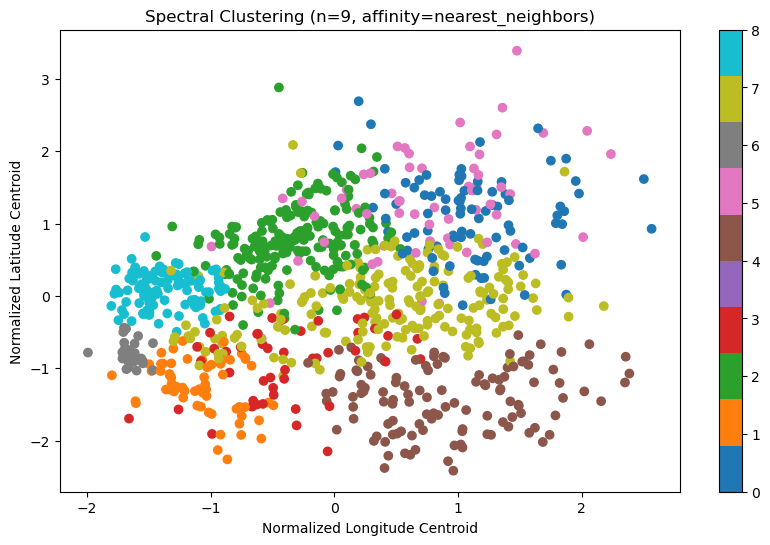


Cluster sizes:
Cluster 0: 90 points
Cluster 1: 61 points
Cluster 2: 192 points
Cluster 3: 47 points
Cluster 4: 117 points
Cluster 5: 64 points
Cluster 6: 32 points
Cluster 7: 204 points
Cluster 8: 101 points

Number of clusters: 10
Silhouette Score: 0.187


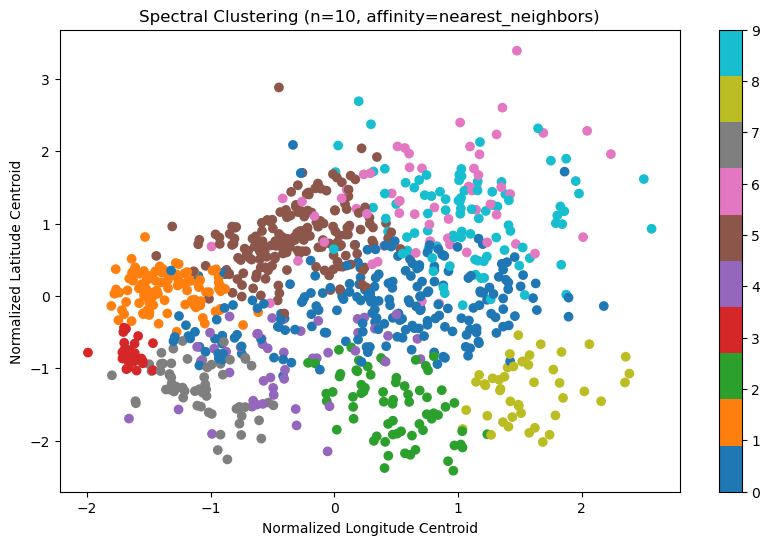


Cluster sizes:
Cluster 0: 217 points
Cluster 1: 102 points
Cluster 2: 69 points
Cluster 3: 32 points
Cluster 4: 47 points
Cluster 5: 181 points
Cluster 6: 64 points
Cluster 7: 59 points
Cluster 8: 45 points
Cluster 9: 92 points

Number of clusters: 11
Silhouette Score: 0.181


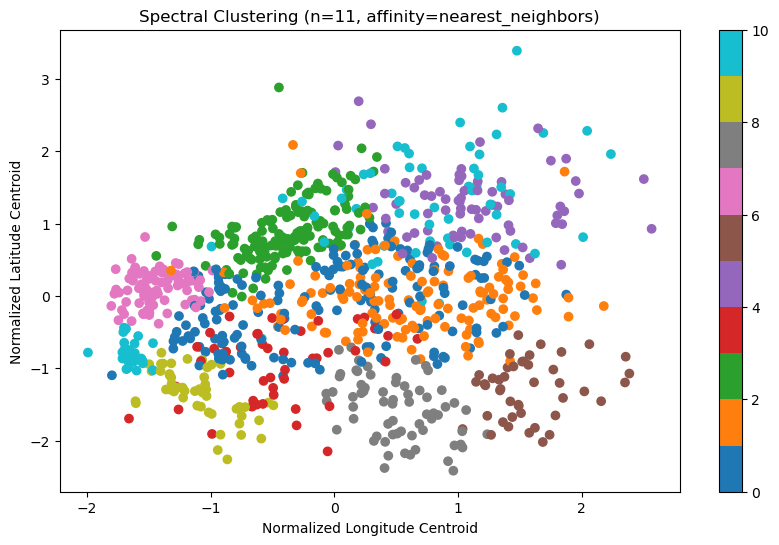


Cluster sizes:
Cluster 0: 169 points
Cluster 1: 142 points
Cluster 2: 145 points
Cluster 3: 46 points
Cluster 4: 73 points
Cluster 5: 44 points
Cluster 6: 83 points
Cluster 7: 66 points
Cluster 8: 49 points
Cluster 9: 32 points
Cluster 10: 59 points

Number of clusters: 12
Silhouette Score: 0.191


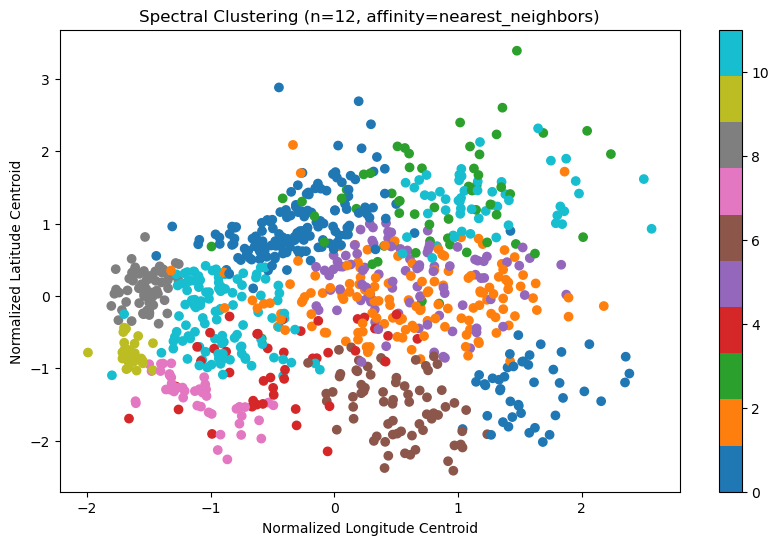


Cluster sizes:
Cluster 0: 44 points
Cluster 1: 151 points
Cluster 2: 145 points
Cluster 3: 60 points
Cluster 4: 43 points
Cluster 5: 92 points
Cluster 6: 70 points
Cluster 7: 43 points
Cluster 8: 62 points
Cluster 9: 32 points
Cluster 10: 54 points
Cluster 11: 112 points


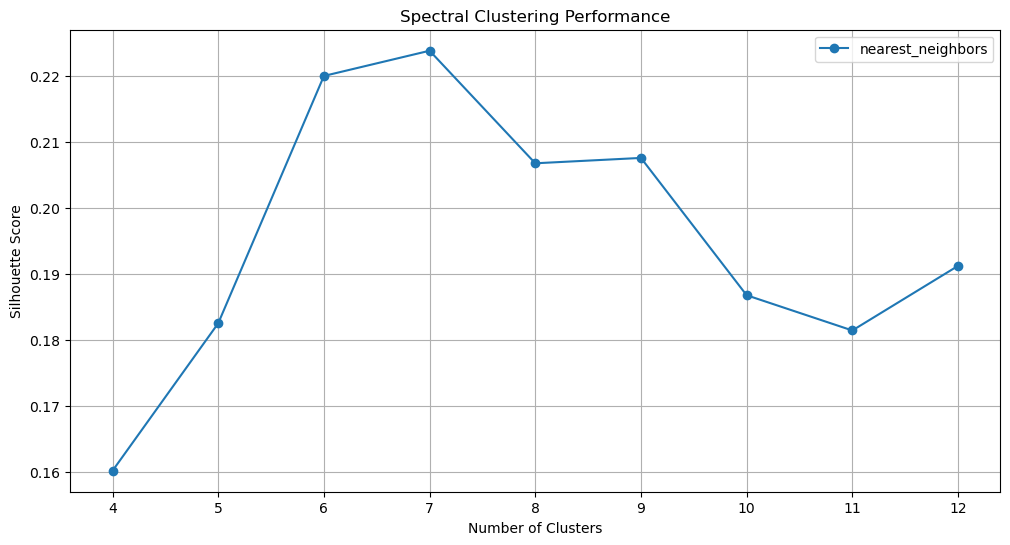


Clustering Comparison:
K-means Silhouette Score: 0.084
GMM Silhouette Score: 0.043
Best Spectral Silhouette Score: 0.224
(using nearest_neighbors affinity and 7 clusters)


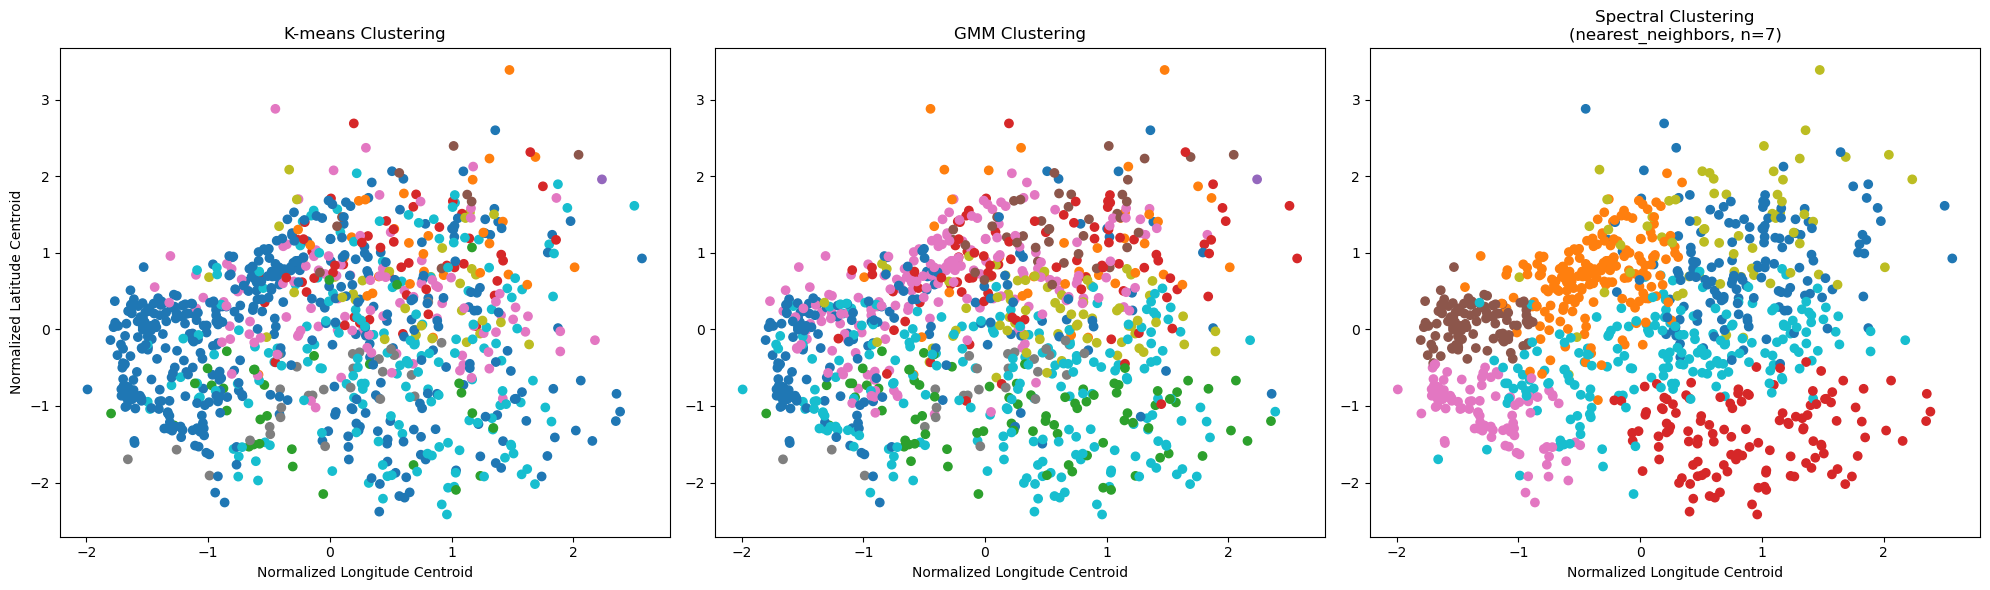

In [16]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Try different numbers of clusters and affinity metrics
n_clusters_range = [4, 5, 6, 7, 8, 9, 10, 11, 12]  # Including original K=6 from paper
affinity_types = ['nearest_neighbors'] 

results = {}

for affinity in affinity_types:
    print(f"\nTesting {affinity} affinity:")
    
    for n_clusters in n_clusters_range:
        # Fit Spectral Clustering
        spectral = SpectralClustering(n_clusters=n_clusters, 
                                    affinity=affinity,
                                    random_state=42)
        spectral_labels = spectral.fit_predict(moment_array_normalized)
        
        # Calculate silhouette score
        silhouette = silhouette_score(moment_array_normalized, spectral_labels)
        
        print(f"\nNumber of clusters: {n_clusters}")
        print(f"Silhouette Score: {silhouette:.3f}")
        
        # Store results
        results[(affinity, n_clusters)] = {
            'labels': spectral_labels,
            'silhouette': silhouette
        }
        
        # Plot clusters
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(moment_array_normalized[:, 0], 
                            moment_array_normalized[:, 1],
                            c=spectral_labels, 
                            cmap='tab10')
        plt.title(f'Spectral Clustering (n={n_clusters}, affinity={affinity})')
        plt.xlabel('Normalized Longitude Centroid')
        plt.ylabel('Normalized Latitude Centroid')
        plt.colorbar(scatter)
        plt.show()
        
        # Print cluster sizes
        print("\nCluster sizes:")
        for i in range(n_clusters):
            print(f"Cluster {i}: {np.sum(spectral_labels == i)} points")

# Plot silhouette scores comparison
plt.figure(figsize=(12, 6))
for affinity in affinity_types:
    scores = [results[(affinity, n)]['silhouette'] for n in n_clusters_range]
    plt.plot(n_clusters_range, scores, 'o-', label=affinity)

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Spectral Clustering Performance')
plt.legend()
plt.grid(True)
plt.show()

# Compare best spectral result with K-means and GMM
best_affinity, best_n = max(results.items(), key=lambda x: x[1]['silhouette'])[0]
best_spectral_labels = results[(best_affinity, best_n)]['labels']

print("\nClustering Comparison:")
print(f"K-means Silhouette Score: {silhouette_score(moment_array_normalized, kmeans_labels):.3f}")
print(f"GMM Silhouette Score: {silhouette_score(moment_array_normalized, gmm_labels):.3f}")
print(f"Best Spectral Silhouette Score: {silhouette_score(moment_array_normalized, best_spectral_labels):.3f}")
print(f"(using {best_affinity} affinity and {best_n} clusters)")

# Plot best clustering results side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-means
scatter = axes[0].scatter(moment_array_normalized[:, 0], 
                         moment_array_normalized[:, 1],
                         c=kmeans_labels, 
                         cmap='tab10')
axes[0].set_title('K-means Clustering')
axes[0].set_xlabel('Normalized Longitude Centroid')
axes[0].set_ylabel('Normalized Latitude Centroid')

# GMM
scatter = axes[1].scatter(moment_array_normalized[:, 0], 
                         moment_array_normalized[:, 1],
                         c=gmm_labels, 
                         cmap='tab10')
axes[1].set_title('GMM Clustering')
axes[1].set_xlabel('Normalized Longitude Centroid')

# Best Spectral
scatter = axes[2].scatter(moment_array_normalized[:, 0], 
                         moment_array_normalized[:, 1],
                         c=best_spectral_labels, 
                         cmap='tab10')
axes[2].set_title(f'Spectral Clustering\n({best_affinity}, n={best_n})')
axes[2].set_xlabel('Normalized Longitude Centroid')

plt.tight_layout()
plt.show()

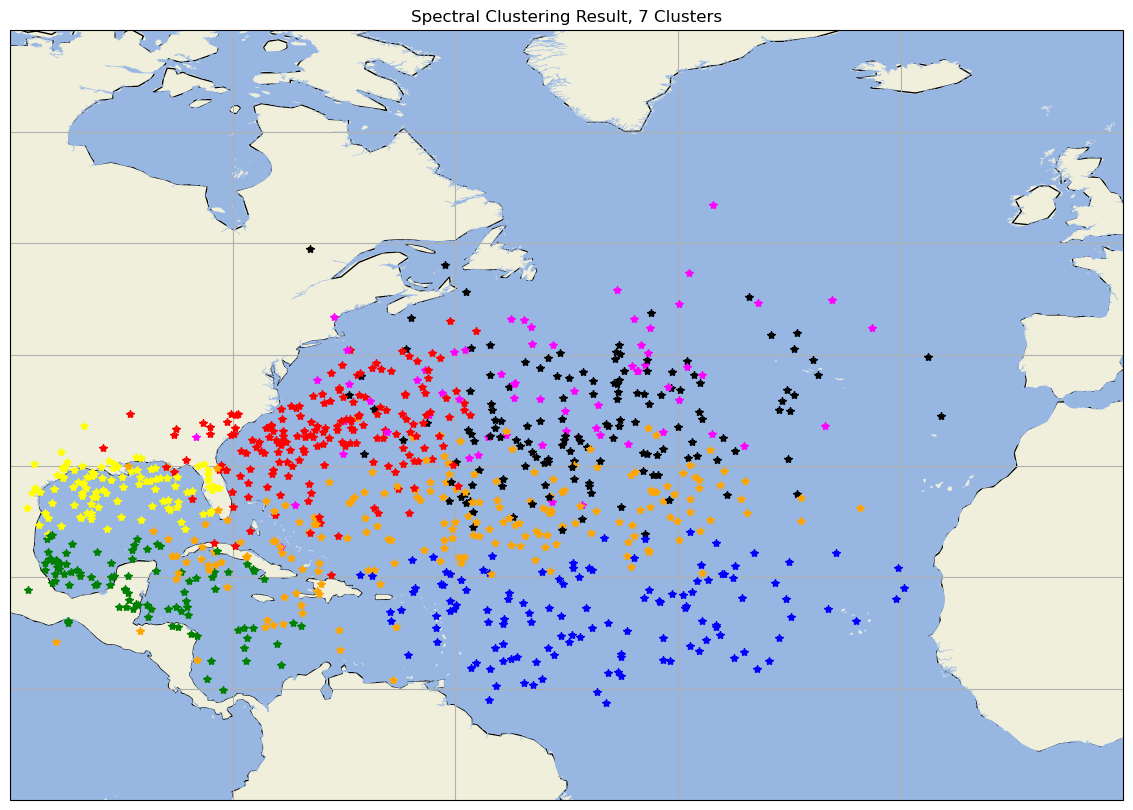

In [17]:
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 
          'orange', 'gray', 'white', 'cyan', 'purple', 'brown']
ax = map_background() 
for k in range(len(moment_array)):
    ax.plot(moment_array[k][0], moment_array[k][1], c=colors[best_spectral_labels[k]], marker='*')
plt.title(f'Spectral Clustering Result, {7} Clusters')
plt.show()

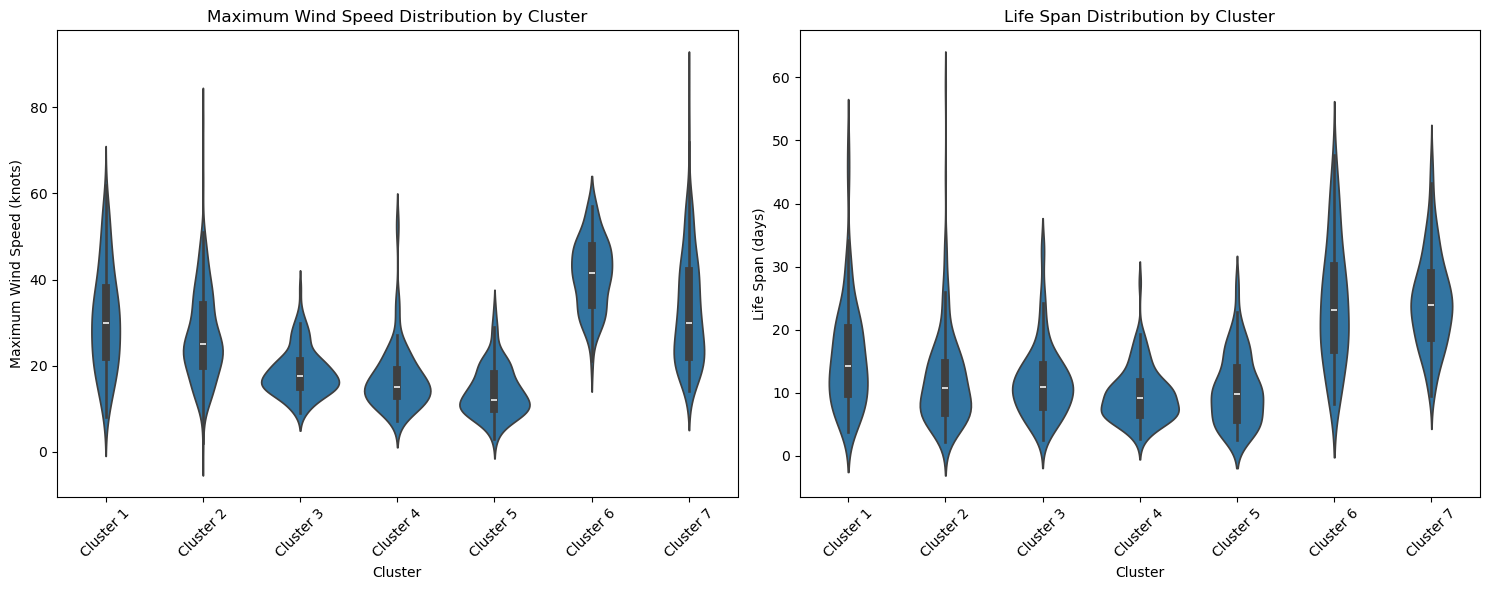


Cluster 1 Statistics:
Number of storms: 145
Average maximum wind speed: 30.9 knots
Average life span: 15.7 days

Cluster 2 Statistics:
Number of storms: 181
Average maximum wind speed: 27.1 knots
Average life span: 12.2 days

Cluster 3 Statistics:
Number of storms: 124
Average maximum wind speed: 18.4 knots
Average life span: 11.8 days

Cluster 4 Statistics:
Number of storms: 101
Average maximum wind speed: 17.0 knots
Average life span: 9.6 days

Cluster 5 Statistics:
Number of storms: 97
Average maximum wind speed: 13.9 knots
Average life span: 10.5 days

Cluster 6 Statistics:
Number of storms: 66
Average maximum wind speed: 41.3 knots
Average life span: 24.3 days

Cluster 7 Statistics:
Number of storms: 194
Average maximum wind speed: 33.1 knots
Average life span: 24.5 days


In [18]:
# Initialize lists to store data for all clusters
all_max_winds = []
all_lifespans = []
cluster_labels = []

for i in range(7):
    cluster_indices = np.where(best_spectral_labels == i)[0]
    
    # Get storms in this cluster
    cluster_storms = [tks.sel(storm=valid_storms.values.nonzero()[0][idx]) 
                     for idx in cluster_indices]
    
    # Calculate statistics
    max_winds = [np.nanmax(storm.storm_speed.values) for storm in cluster_storms]
    lifespans = [np.sum(~np.isnan(storm.lon.values)) * 6 / 24 for storm in cluster_storms]
    
    all_max_winds.extend(max_winds)
    all_lifespans.extend(lifespans)
    cluster_labels.extend([f'Cluster {i+1}'] * len(cluster_indices))

# Create violin plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot wind speeds
sns.violinplot(x=cluster_labels, y=all_max_winds, ax=ax1)
ax1.set_title('Maximum Wind Speed Distribution by Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Maximum Wind Speed (knots)')
ax1.tick_params(axis='x', rotation=45)

# Plot lifespans
sns.violinplot(x=cluster_labels, y=all_lifespans, ax=ax2)
ax2.set_title('Life Span Distribution by Cluster')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Life Span (days)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
for i in range(7):
    cluster_indices = np.where(best_spectral_labels == i)[0]
    print(f"\nCluster {i+1} Statistics:")
    print(f"Number of storms: {len(cluster_indices)}")
    print(f"Average maximum wind speed: {np.mean([w for j, w in enumerate(all_max_winds) if cluster_labels[j] == f'Cluster {i+1}']):.1f} knots")
    print(f"Average life span: {np.mean([l for j, l in enumerate(all_lifespans) if cluster_labels[j] == f'Cluster {i+1}']):.1f} days")


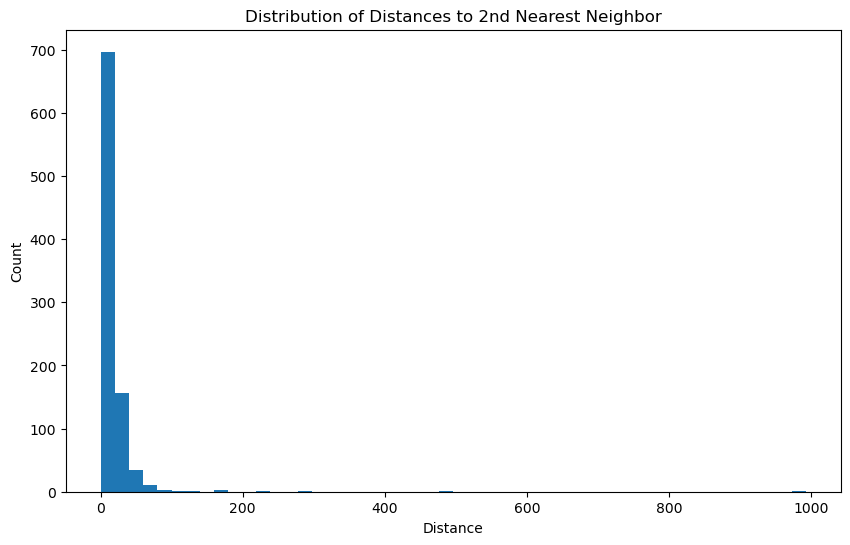

Distance statistics:
Mean distance: 17.344
Median distance: 10.491
75th percentile: 19.040

DBSCAN with eps=10.491
Number of clusters: 4
Number of noise points: 604
Percentage of points classified as noise: 66.5%


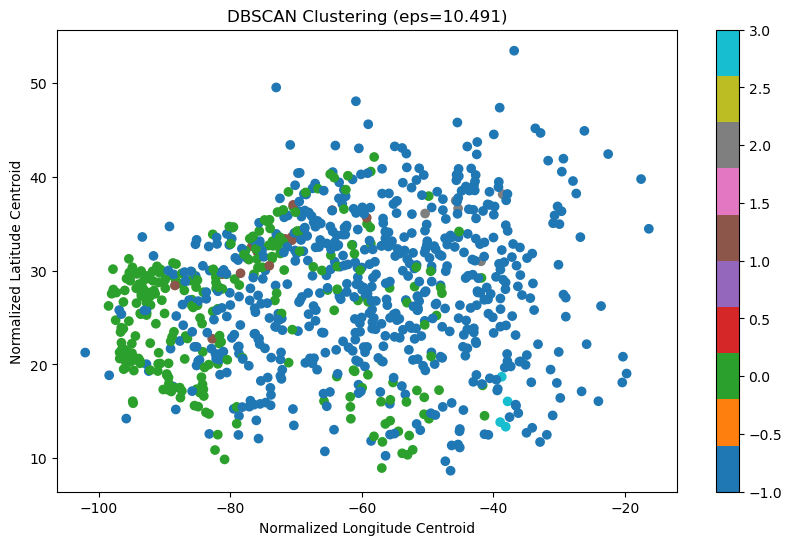


Cluster sizes:
Cluster 0: 281 points
Cluster 1: 14 points
Cluster 2: 5 points
Cluster 3: 4 points

DBSCAN with eps=12.628
Number of clusters: 4
Number of noise points: 519
Percentage of points classified as noise: 57.2%


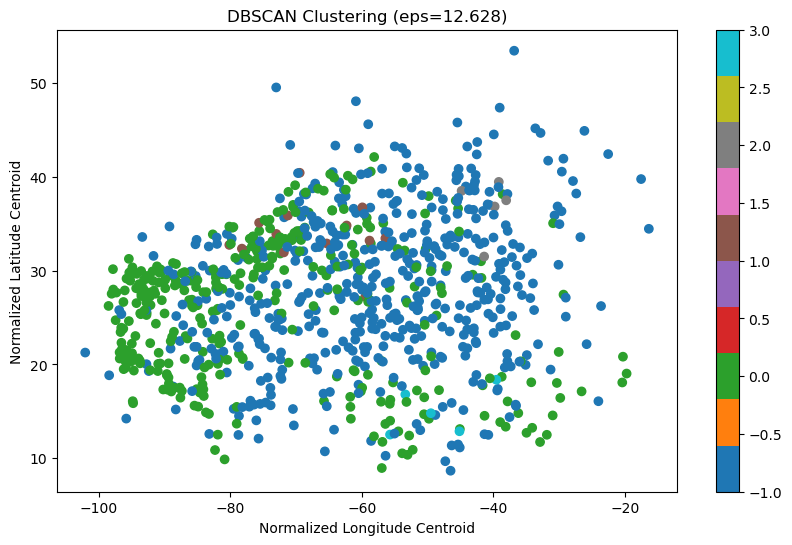


Cluster sizes:
Cluster 0: 365 points
Cluster 1: 14 points
Cluster 2: 5 points
Cluster 3: 5 points

DBSCAN with eps=14.766
Number of clusters: 6
Number of noise points: 446
Percentage of points classified as noise: 49.1%


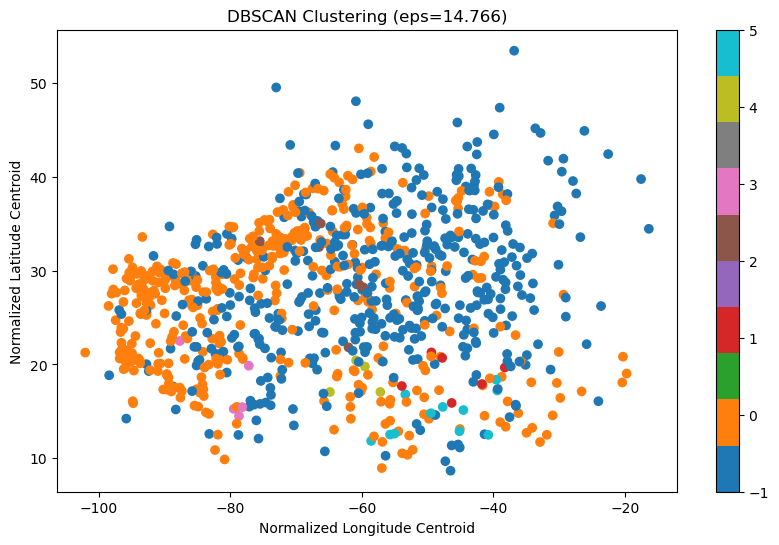


Cluster sizes:
Cluster 0: 430 points
Cluster 1: 6 points
Cluster 2: 6 points
Cluster 3: 5 points
Cluster 4: 4 points
Cluster 5: 11 points

DBSCAN with eps=16.903
Number of clusters: 5
Number of noise points: 388
Percentage of points classified as noise: 42.7%


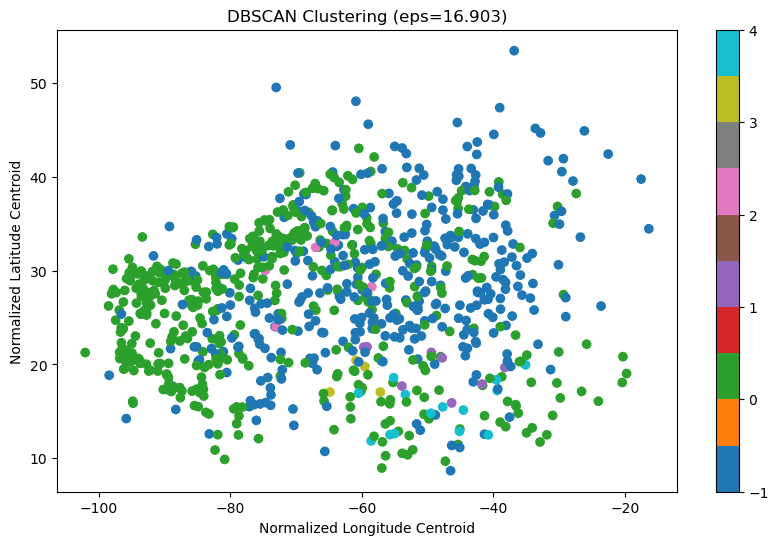


Cluster sizes:
Cluster 0: 489 points
Cluster 1: 8 points
Cluster 2: 5 points
Cluster 3: 4 points
Cluster 4: 14 points

DBSCAN with eps=19.040
Number of clusters: 3
Number of noise points: 352
Percentage of points classified as noise: 38.8%


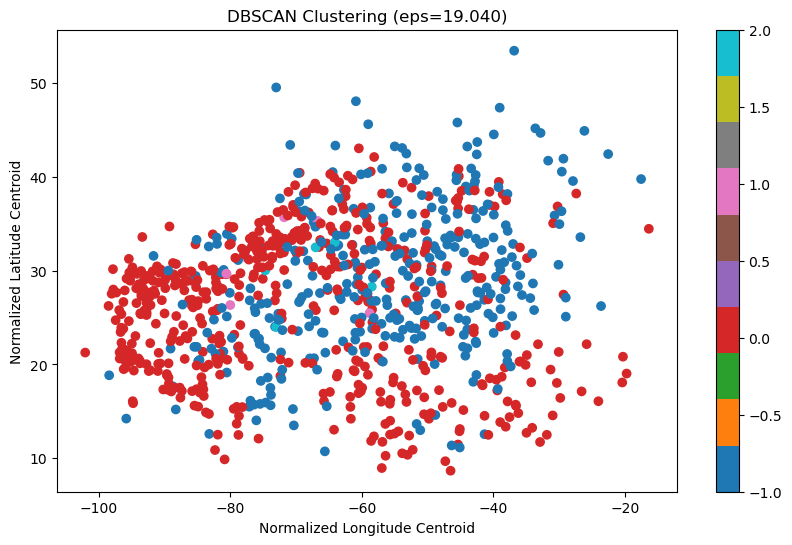


Cluster sizes:
Cluster 0: 545 points
Cluster 1: 6 points
Cluster 2: 5 points


In [19]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# First, let's better understand the distance distribution in our data
neigh = NearestNeighbors(n_neighbors=5)  # increased to see more neighbors
nbrs = neigh.fit(moment_array)
distances, indices = nbrs.kneighbors(moment_array)

# Plot distances to nearest neighbors
plt.figure(figsize=(10, 6))
plt.hist(distances[:, 1], bins=50)  # Plot distance to 2nd nearest neighbor
plt.title('Distribution of Distances to 2nd Nearest Neighbor')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.show()

print("Distance statistics:")
print(f"Mean distance: {np.mean(distances[:, 1]):.3f}")
print(f"Median distance: {np.median(distances[:, 1]):.3f}")
print(f"75th percentile: {np.percentile(distances[:, 1], 75):.3f}")

# Try a range of eps values based on the distance distribution
eps_values = np.linspace(np.median(distances[:, 1]), 
                        np.percentile(distances[:, 1], 75), 
                        5)

# Try DBSCAN with these more informed parameters
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(moment_array)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    print(f"\nDBSCAN with eps={eps:.3f}")
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print(f"Percentage of points classified as noise: {(n_noise/len(dbscan_labels))*100:.1f}%")
    
    if n_clusters >= 2:  # Only plot if we have at least 2 clusters
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(moment_array[:, 0], 
                            moment_array[:, 1], 
                            c=dbscan_labels, 
                            cmap='tab10')
        plt.title(f'DBSCAN Clustering (eps={eps:.3f})')
        plt.xlabel('Normalized Longitude Centroid')
        plt.ylabel('Normalized Latitude Centroid')
        plt.colorbar(scatter)
        plt.show()

        # Print cluster sizes
        unique_labels = set(dbscan_labels)
        print("\nCluster sizes:")
        for label in unique_labels:
            if label != -1:
                print(f"Cluster {label}: {np.sum(dbscan_labels == label)} points")

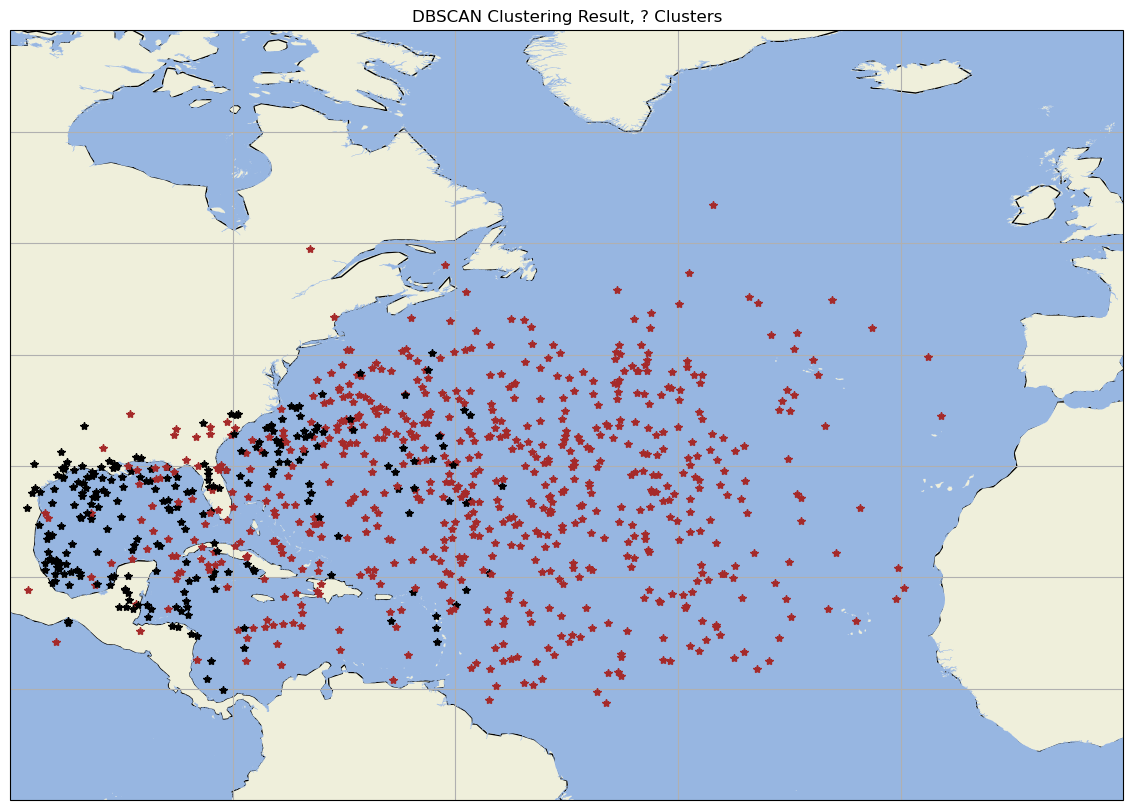

In [20]:
dbscan = DBSCAN(eps=20, min_samples=100)
dbscan_labels = dbscan.fit_predict(moment_array)

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 
          'orange', 'gray', 'white', 'cyan', 'purple', 'brown']
ax = map_background() 
for k in range(len(moment_array)):
    ax.plot(moment_array[k][0], moment_array[k][1], c=colors[dbscan_labels[k]], marker='*')
plt.title(f'DBSCAN Clustering Result, ? Clusters')
plt.show()

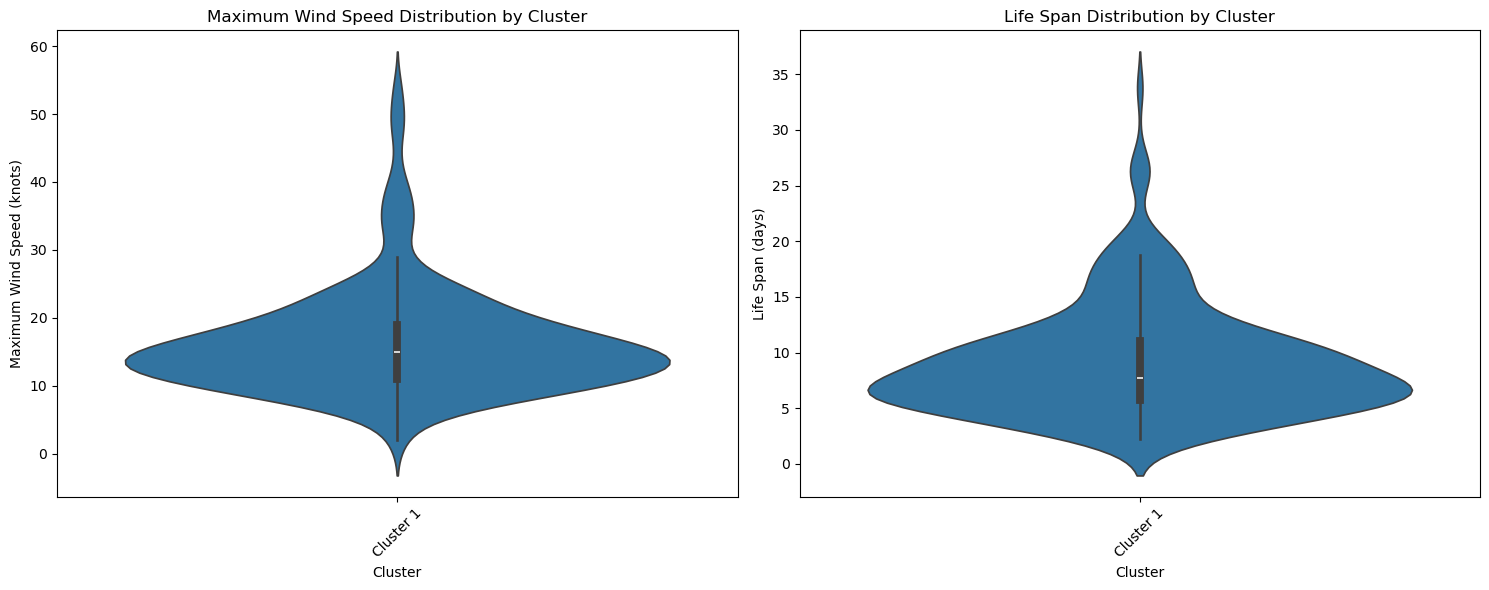


Cluster 1 Statistics:
Number of storms: 245
Average maximum wind speed: 16.3 knots
Average life span: 9.1 days

Cluster 2 Statistics:
Number of storms: 0
Average maximum wind speed: nan knots
Average life span: nan days


In [21]:
# Initialize lists to store data for all clusters
all_max_winds = []
all_lifespans = []
cluster_labels = []

for i in range(2):
    cluster_indices = np.where(dbscan_labels == i)[0]
    
    # Get storms in this cluster
    cluster_storms = [tks.sel(storm=valid_storms.values.nonzero()[0][idx]) 
                     for idx in cluster_indices]
    
    # Calculate statistics
    max_winds = [np.nanmax(storm.storm_speed.values) for storm in cluster_storms]
    lifespans = [np.sum(~np.isnan(storm.lon.values)) * 6 / 24 for storm in cluster_storms]
    
    all_max_winds.extend(max_winds)
    all_lifespans.extend(lifespans)
    cluster_labels.extend([f'Cluster {i+1}'] * len(cluster_indices))

# Create violin plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot wind speeds
sns.violinplot(x=cluster_labels, y=all_max_winds, ax=ax1)
ax1.set_title('Maximum Wind Speed Distribution by Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Maximum Wind Speed (knots)')
ax1.tick_params(axis='x', rotation=45)

# Plot lifespans
sns.violinplot(x=cluster_labels, y=all_lifespans, ax=ax2)
ax2.set_title('Life Span Distribution by Cluster')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Life Span (days)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
for i in range(2):
    cluster_indices = np.where(dbscan_labels == i)[0]
    print(f"\nCluster {i+1} Statistics:")
    print(f"Number of storms: {len(cluster_indices)}")
    print(f"Average maximum wind speed: {np.mean([w for j, w in enumerate(all_max_winds) if cluster_labels[j] == f'Cluster {i+1}']):.1f} knots")
    print(f"Average life span: {np.mean([l for j, l in enumerate(all_lifespans) if cluster_labels[j] == f'Cluster {i+1}']):.1f} days")
